# Project: Predicting house sale prices  
**Data:** housing data for the city of Ames, Iowa, USA, 2006 to 2010  
**Data description:** https://s3.amazonaws.com/dq-content/307/data_description.txt  
**Source:** https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627  
**Source pdf:** https://www.tandfonline.com/doi/pdf/10.1080/10691898.2011.11889627?needAccess=true








PDF excerpts:  
    "This paper presents a data set describing the sale of individual residential property in Ames, Iowa
from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory
variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home
values. I will discuss my previous use of the Boston Housing Data Set and I will suggest
methods for incorporating this new data set as a final project in an undergraduate regression
course."

here are
five observations that an instructor may wish to remove from the data set before giving
it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these
points). Three of them are true outliers (Partial Sales that likely don’t represent actual
market values) and two of them are simply unusual sales (very large houses priced
relatively appropriately). I would recommend removing any houses with more than
4000 square feet from the data set (which eliminates these five unusual observations)
before assigning it to students.


specific recommendations:

Eliminate all sales except for the “normal” from the SALES CONDITION variable.
Unless an instructor specifically wants to create an activity that investigates the
difference between the various types of sales (foreclosures, new homes, family sales, etc.)
the different conditions will simply serve to complicate the results and confuse the
students.  

Remove all homes with a living area (GR LIVE AREA) above 1500 square feet. The
purpose to the second step is to alleviate problems with non-homogeneous variance. As
might be expected there is increasing variation with increasing price within the Ames
housing market. This problem can be remedied by taking a transformation (square root)
of the sales price but those wishing to keep the response in dollars can simply use the
smaller homes as they tend to show more homogeneous variation.  

Select desired observations.
Although the data set could be reduced further using other variables (such as using only
one story homes or eliminating homes without a basement), I would recommend drawing
a simple random (or systematic) sample from the remaining “normal” sales to create the
final data set.  

## 1. Setting-up project environment

### 1.1 Importing packages & data

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
from scipy.stats import mstats
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from itertools import combinations # check if needed later
from itertools import chain
from datetime import date #check if needed later
from dython import nominal
from optbinning import ContinuousOptimalBinning
import math
import distfit #distribution fitting
import pylab
from IPython.display import display, HTML
%matplotlib inline
import session_info


# Setting pandas display options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 100

In [2]:
# Collecting packages info and saving to requirements.txt file
session_info.show(cpu = True, std_lib = True, dependencies = True, write_req_file = True,
                  req_file_name = 'requirements.txt')

### 1.2 Source Dataset

In [3]:
data = pd.read_csv('C:\\Users\\tgusc\\Documents\\GitHub\\Python\\GP23_PredictingHouseSalePrices\\AmesHousing.tsv',
                   delimiter="\t")

### Useful links

Inspiration notebooks:
* https://www.kaggle.com/code/solegalli/feature-engineering-for-house-price-modelling
* https://nycdatascience.com/blog/student-works/house-price-prediction-with-creative-feature-engineering-and-advanced-regression-techniques/
* https://rpubs.com/IsaacGabr/795734
* https://www.kaggle.com/code/modassirafzal/housing-top-3/notebook


Feature Engineering:
* https://towardsdatascience.com/churn-analysis-information-value-and-weight-of-evidence-6a35db8b9ec5  
* https://contrib.scikit-learn.org/category_encoders/woe.html  
* https://multithreaded.stitchfix.com/blog/2015/08/13/weight-of-evidence  
* https://contrib.scikit-learn.org/category_encoders/polynomial.html  
* https://contrib.scikit-learn.org/category_encoders/targetencoder.html 
* https://stackoverflow.com/questions/46428870/how-to-handle-date-variable-in-machine-learning-data-pre-processing
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.winsorize.html
* https://www.lexjansen.com/sesug/2014/SD-20.pdf
* https://arxiv.org/pdf/2001.08025.pdf (Optbinning library)

Correlation for non-numeric data (Dython library):  
* https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

Variable standarization:  
http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf

Variable selection:  
* https://github.com/scikit-learn-contrib/boruta_py

Optimal Binning and WoE transformation for continuous dependent variable:
* http://gnpalencia.org/optbinning/binning_continuous.html
* https://www.listendata.com/2019/08/WOE-IV-Continuous-Dependent.html


### 1.3 Parameters

In [4]:
#MANUAL_INPUT - mark of sections of code, that are not automated and have to be manually re-coded to new datasets.

#parameters
seed = 123
target = 'SalePrice'
ID_vars = ['Order', 'PID']
strong_correlation_param = 0.8 # cut-off value of Pearson correlation to indicate strong correlations

# Non-numeric variables parameters

low_corr_category_parm = 0.3 # cut-off value for categorical variables correlation.
levels_discrete = 20 # how many levels (unique values) can a numeric variable have to be considered as discrete variable 
c_miss_cutoff = 0.8 # delete non-numeric variables that have more than c_miss_cutoff missing values

# Numeric variables paramaters

n_miss_cutoff = 0.25 # delete numeric variables that have more than n_miss_cutoff missing values
n_fill_cutoff = 0.05 # if missing values for numeric variables is ge than n_fill cutoff, use n_fill_method to impute values
n_fill_cutoff = 'mode' # numeric variables imputation method for missing values

#Train valid test split
test_split = 0.8 # 20% of total observations will be assigned to test dataset
valid_split = 0.8 # 20% of train_valid observations ( test_split * total observations) will be assigned to
# validation dataset

# Datasets explained

# data_transformed - data post missing values handling and inputation
# train - train dataset (post sampling)
# valid - valid dataset (post sampling)
# train_valid - concatenated train and valid datasets (post sampling). Used for CV purposes.
# test - holdout data for final accuracy confirmation.

### 1.4 Functions

In [5]:
def var_boxplot(var, data, target, title, xrotate = 0):
    """
    Create boxplot of variable vs descending median of target and provide frequency table for variable values. Caution:
    target variable has to be numeric.
    
    Parameters
    ----------
    data : str
        DataFrame to plot and calculate frequencies
    var : str
        Variable name for analysis. Provide in quotation marks.
    target : str
        Target variable name for analysis. Provide in quotation marks.
    title : str
        Target variable name for analysis. Provide in quotation marks.
    xrotate : int
        Rotation parameter for plt.xticks. By default 0.

    Returns
    -------
    Prints out a boxplot and frequency table.
    """
    plt.figure(figsize=(10,5))
    sn.boxplot(x= var, y=target, data=data)
    plt.title(title)
    plt.xlabel(var)
    plt.ylabel('Median of '+str(target))
    plt.xticks(rotation= xrotate)
    plt.show()

    valueCounts = pd.concat([data[var].value_counts(), 
                data[var].value_counts(normalize=True).mul(100)],axis=1, keys=('counts','percentage'))
    print(var,'\n',len(data[var].unique()),'unique values: ')
    display(HTML(valueCounts.to_html()))

In [6]:
def transform_features(data_in, cutoff_missing = 0.25, cutoff_fill = 0.05, fill_method = 'mode'):
    """
    Transform features based on their characteristics.
    
    Parameters
    ----------
    data_in : str
        DataFrame to analyze.
    cutoff_missing : float64, default = 0.25
        Percentage of missing values used as cutoff point for dropping variable. If missings > cutoff_missing then
        drop variable from DataFrame.
    cutoff_fill : float64, default = 0.05
        Percentage of missing values used as cutoff point for filling missing variables with fill_method. If 
        missings < cutoff_fill then replace missing values with fill_method and create new variable var_name + "_NA"
        which indicates rows with missing values for original variable
    fill_method : str, default = 'mode'
        Filling method for missing values, when variable meets cutoff_fill criteria. Can choose from average, median, mode.    
    seed : int
        Random number seed for results reproductibility.
    train_pct : float64, default 0.8
        Percentage of DS dataset to be used as train. 
        
    Returns
    -------
    data_out : DataFrame
        DataFrame with transformed features.
    """
    data_out = pd.DataFrame()
    missing_info = data_in.isna().sum()/len(data_in)
    dropped_cols = []
    for col in numerical:
        p_miss = missing_info[missing_info.index == col][0]
        if p_miss > cutoff_missing:
            print(col + ' - dropped because of missing values exceeding ' + str(cutoff_missing) + '%.' +
                  ' Missing values = '
                 + str(round(p_miss*100,2)) + '%.')
            dropped_cols.append(col)
    for col_n in data_in.select_dtypes('number'):
        p_miss = missing_info[missing_info.index == col_n][0]
        if ((p_miss <= cutoff_fill) & (p_miss > 0)):
            if fill_method == 'mode':
                fill=data_in[col_n].mode()[0]
            elif fill_method == 'mean':
                fill=np.mean(data_in[col_n])
            elif fill_method == 'median':
                fill=np.median(data_in[col_n])
            else:
                print(fill_method + ' is not known. Column will not be transformed')
                continue
            data_out[col_n+'_NA'] = np.where(data_in[col_n].isnull(), 1, 0) # Adding variable indicating missing value
            data_out[col_n] = data_in[col_n].fillna(value = fill)
            print(col_n + ' - ' + str(round(p_miss*100,4)) + '% of missing values. They are replaced with '
                  + fill_method + ' value - ' + str(fill))
            print(col_n+'_NA' + ' is created to indicate missing values of original variable.')
        else :
            data_out[col_n] = data_in[col_n]
            print(col_n + ' - ' + str(round(p_miss*100,4)) + '% of missing values. Variable copied.')
    for col_c in data_in.select_dtypes(exclude='number'):
            data_out[col_c] = data_in[col_c].astype('category')
    return data_out

In [8]:
def Optbin_create(X_df, y, var_list, prebin_method="quantile", cat_coff = 0.01, n_bins = 10):
    """
    Creates dictonary storing for each variable from var_list (has to be subset of X_df DataFrame) grouped to
    similar categories via continuous optimal binning function from optbinning library. This results in dictionary
    per variable containing optimal binning specification and Weight Of Evidence + Information Value calculations.
    WoE and IV values have been recalculated in this function, as currently in optbinning library WoE is calculated only
    for binary dependent variable. Formula for continuous calculation is taken from listendata.com (see: Source
    materials 2.)
    
    Library import: from optbinning import ContinuousOptimalBinning
    
    Source materials: 
    1. http://gnpalencia.org/optbinning/binning_continuous.html 
    2. https://www.listendata.com/2019/08/WOE-IV-Continuous-Dependent.html
    
    Parameters
    ----------
    X_df : str
        DataFrame with independent variables to analyze.
    y : str
        Series with dependent variable. Must be continuous.
    Var_list : str
        List of variable names to create optimal bins for and calculate WoE/IV/Target encoders. Must be a subset of X_df
        columns.
    prebin_method : str, default = "quantile"
        Quoting source materials 2. : "The pre-binning method. Supported methods are “cart” for a CART decision tree, 
        “quantile” to generate prebins with approximately same frequency and “uniform” to generate prebins 
        with equal width."
    cat_coff : float, default = 0.01
        If category size is less than cat_coff % (default 1%) of total population , then it will be grouped in separate
        group. All categories with size lesser than cat_coff % will be grouped together.
    n_bins : int, default = 10
        Max limit to number of bins (grouped categories).
        
    Returns
    -------
    optbin_dict : Dictionary
        optbin_dict[i]["optbin"] - metadata about transformation, parameter values
        optbin_dict[i]["bin_table"] - table containing information about grouped category variables with below 
            variables:
                Bin - list of values representing grouped categories
                Count - number of observations in bin
                Count % - % of all observations in dataset
                Sum - sum of dependent variable by bin
                Mean - mean of dependent variable by bin
                Min - minimum value of dependent variable by bin
                Max - maximum value of dependent variable by bin
                Zeros count - counting "0" values of dependent variable by bin
                WoE - Weight of Evidence calculation as per source materials 2.
                IV - Information Value specyfiying prediction power by bin
    """
    optbin_dict = {}
    for i in var_list:
        target_sum = y.sum()
        optbin_dict[i] = {}
        optbin = ContinuousOptimalBinning(name=i, prebinning_method=prebin_method, dtype="categorical", 
                                          cat_cutoff = cat_coff, max_n_prebins = n_bins)
        optbin_dict[i]["optbin"] = optbin
        optbin_dict[i]["optbin"] = optbin_dict[i]["optbin"].fit(X_df[i], y)
        bin_table = optbin_dict[i]["optbin"].binning_table.build()
        optbin_dict[i]["bin_table"] = bin_table
        optbin_dict[i]["bin_table"]["WoE"] = np.log((optbin_dict[i]["bin_table"]['Sum']/target_sum) /
                                                    optbin_dict[i]["bin_table"]['Count (%)'])
        optbin_dict[i]["bin_table"]["IV"] = ((optbin_dict[i]["bin_table"]['Sum']/target_sum) - 
                                             optbin_dict[i]["bin_table"]['Count (%)']) * optbin_dict[i]["bin_table"]["WoE"]
        optbin_dict[i]["bin_table"]["WoE"].fillna(0, inplace = True)
        optbin_dict[i]["bin_table"]["IV"].fillna(0, inplace = True)
        optbin_dict[i]["bin_table"].at['Totals', 'IV'] = optbin_dict[i]["bin_table"].iloc[:-1]['IV'].sum()
        IV_temp = optbin_dict[i]["bin_table"].at['Totals', 'IV']
        if IV_temp <= 0.02 :
            print(i,'- IV suggests not useful for prediction - ', IV_temp)
        elif IV_temp <= 0.1 :
            print(i,'- IV suggests weak predictive power - ', IV_temp)
        elif IV_temp <= 0.3 :
            print(i,'- IV suggests medium predictive power - ', IV_temp)
        elif IV_temp <= 0.5 :
            print(i,'- IV suggests strong predictive power - ', IV_temp)
        else:
            print(i,'- IV suggests suspicious predictive power -', IV_temp)
    return optbin_dict


def VarTransform(data, var_name, optbin_dict, metric = "WoE"):
    """
    Transforming variable var_name from Dataframe data using optbin_dict to return encoded value of Weight of Evidence 
    (WoE) or mean dependent value from corresponding bin (see Optbin_create function).
    
    Further possible enhancements: adding troubleshooting like try except instructions for values of metric outside ["WoE",
    "Mean"] list. Currently for every value that is not equal to "WoE" function will transform variable using "Mean" 
    metric.
    
    Parameters
    ----------
    data : str
        DataFrame to analyze.
    var_name : str
        Variable name (dtype = categorical) from data that will be transformed for corresponding metric from optbin_dict.
    optbin_dict : str
        Dictionary name from Optbin_create function. Storing information about optimal bins (grouped categories) and 
        corresponding Weight of Evidence (WoE) and mean dependent variable value from bin.
    metric : str, default = 'WoE'
        Metric to be returned instead of var_name category. Returns optbin_dict[var_name]["bin_table"]["WoE"] for "Woe"
        value or optbin_dict[var_name]["bin_table"]["Mean"] for "Mean" value.
        
    Returns
    -------
    transformed : Series
        Series representing transformed variable from category to float values.
    """
    optbin = optbin_dict[var_name]["bin_table"]
    clean = optbin[['Bin','Mean','WoE','Count']].explode('Bin')
    clean.reset_index(drop = True, inplace = True)
    clean = clean[clean.Count != 0]
    clean.drop(columns = 'Count', inplace = True)
    clean.loc['Other'] = clean.iloc[-1]
    clean.at['Other', 'Bin']='Other'
    if metric == 'WoE':
        dict_clean=clean.set_index("Bin")["WoE"].to_dict()
    else:
        dict_clean=clean.set_index("Bin")["Mean"].to_dict()
                        
    for i in pd.Series(data[var_name].unique()):
        if i not in dict_clean:
            print(var_name,':',i,' - value is not present in the binning table')
    transformed = data[var_name].map(dict_clean).fillna(dict_clean['Other'])
    return transformed    

In [9]:
#2023/01/22 continue to document project and move to cross-validation, Feature selection methods and modelling.
#Idea - dict of models with variables, evaluation metrics etc. Graphs of evaluation would be nice as well.
#data_optbin["Garage Type"]

## 2. Exploratory Data Analysis (EDA)

In [11]:
# https://towardsdatascience.com/effortless-exploratory-data-analysis-eda-201c99324857 - 
# pycaret - doesn't work for now
# from pycaret.utils import enable_colab
# enable_colab()
# from pycaret.regression import *

# exp1 = setup(data, target = 'SalePrice')

In [12]:
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [13]:
# MANUAL_INPUT
# MS SubClass is a categorical variable stored as number - we will switch it to category
data["MS SubClass"] = 'C' + data["MS SubClass"].astype(str)

### 2.1 Non-numeric data

In [14]:
# find categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']
print('There are {} categorical variables \n'.format(len(categorical)))

# Creating Series containing missing information
cat_miss = data[categorical].isnull().sum()/data.shape[0]

# changing missing values in categorical variables to 'Missing'
for var in categorical:
    data[var].fillna('Missing', inplace=True)

# Print basic info about variable - % of missing, # of unique values, unique values in data
for var in categorical:
    valueCounts = pd.concat([data[var].value_counts(), 
                data[var].value_counts(normalize=True).mul(100)],axis=1, keys=('counts','percentage'))
    print(var,'\n',len(data[var].unique()),'unique values: ')
    display(HTML(valueCounts.to_html()))

There are 44 categorical variables 

MS SubClass 
 16 unique values: 


,counts,percentage
C20,1079,36.825939
C60,575,19.624573
C50,287,9.795222
C120,192,6.552901
C30,139,4.744027
C160,129,4.402730
C70,128,4.368601
C80,118,4.027304
C90,109,3.720137
C190,61,2.081911


MS Zoning 
 7 unique values: 


,counts,percentage
RL,2273,77.576792
RM,462,15.767918
FV,139,4.744027
RH,27,0.921502
C (all),25,0.853242
I (all),2,0.068259
A (agr),2,0.068259


Street 
 2 unique values: 


,counts,percentage
Pave,2918,99.590444
Grvl,12,0.409556


Alley 
 3 unique values: 


,counts,percentage
Missing,2732,93.242321
Grvl,120,4.095563
Pave,78,2.662116


Lot Shape 
 4 unique values: 


,counts,percentage
Reg,1859,63.447099
IR1,979,33.412969
IR2,76,2.593857
IR3,16,0.546075


Land Contour 
 4 unique values: 


,counts,percentage
Lvl,2633,89.863481
HLS,120,4.095563
Bnk,117,3.993174
Low,60,2.047782


Utilities 
 3 unique values: 


,counts,percentage
AllPub,2927,99.897611
NoSewr,2,0.068259
NoSeWa,1,0.034130


Lot Config 
 5 unique values: 


,counts,percentage
Inside,2140,73.037543
Corner,511,17.440273
CulDSac,180,6.143345
FR2,85,2.901024
FR3,14,0.477816


Land Slope 
 3 unique values: 


,counts,percentage
Gtl,2789,95.187713
Mod,125,4.266212
Sev,16,0.546075


Neighborhood 
 28 unique values: 


,counts,percentage
NAmes,443,15.119454
CollgCr,267,9.112628
OldTown,239,8.156997
Edwards,194,6.621160
Somerst,182,6.211604
NridgHt,166,5.665529
Gilbert,165,5.631399
Sawyer,151,5.153584
NWAmes,131,4.470990
SawyerW,125,4.266212


Condition 1 
 9 unique values: 


,counts,percentage
Norm,2522,86.075085
Feedr,164,5.597270
Artery,92,3.139932
RRAn,50,1.706485
PosN,39,1.331058
RRAe,28,0.955631
PosA,20,0.682594
RRNn,9,0.307167
RRNe,6,0.204778


Condition 2 
 8 unique values: 


,counts,percentage
Norm,2900,98.976109
Feedr,13,0.443686
Artery,5,0.170648
PosA,4,0.136519
PosN,4,0.136519
RRNn,2,0.068259
RRAe,1,0.034130
RRAn,1,0.034130


Bldg Type 
 5 unique values: 


,counts,percentage
1Fam,2425,82.764505
TwnhsE,233,7.952218
Duplex,109,3.720137
Twnhs,101,3.447099
2fmCon,62,2.116041


House Style 
 8 unique values: 


,counts,percentage
1Story,1481,50.546075
2Story,873,29.795222
1.5Fin,314,10.716724
SLvl,128,4.368601
SFoyer,83,2.832765
2.5Unf,24,0.819113
1.5Unf,19,0.648464
2.5Fin,8,0.273038


Roof Style 
 6 unique values: 


,counts,percentage
Gable,2321,79.215017
Hip,551,18.805461
Gambrel,22,0.750853
Flat,20,0.682594
Mansard,11,0.375427
Shed,5,0.170648


Roof Matl 
 8 unique values: 


,counts,percentage
CompShg,2887,98.532423
Tar&Grv,23,0.784983
WdShake,9,0.307167
WdShngl,7,0.238908
Membran,1,0.034130
ClyTile,1,0.034130
Roll,1,0.034130
Metal,1,0.034130


Exterior 1st 
 16 unique values: 


,counts,percentage
VinylSd,1026,35.017065
MetalSd,450,15.358362
HdBoard,442,15.085324
Wd Sdng,420,14.334471
Plywood,221,7.542662
CemntBd,126,4.300341
BrkFace,88,3.003413
WdShing,56,1.911263
AsbShng,44,1.501706
Stucco,43,1.467577


Exterior 2nd 
 17 unique values: 


,counts,percentage
VinylSd,1015,34.641638
MetalSd,447,15.255973
HdBoard,406,13.856655
Wd Sdng,397,13.549488
Plywood,274,9.351536
CmentBd,126,4.300341
Wd Shng,81,2.764505
Stucco,47,1.604096
BrkFace,47,1.604096
AsbShng,38,1.296928


Mas Vnr Type 
 6 unique values: 


,counts,percentage
None,1752,59.795222
BrkFace,880,30.034130
Stone,249,8.498294
BrkCmn,25,0.853242
Missing,23,0.784983
CBlock,1,0.034130


Exter Qual 
 4 unique values: 


,counts,percentage
TA,1799,61.399317
Gd,989,33.754266
Ex,107,3.651877
Fa,35,1.194539


Exter Cond 
 5 unique values: 


,counts,percentage
TA,2549,86.996587
Gd,299,10.204778
Fa,67,2.286689
Ex,12,0.409556
Po,3,0.102389


Foundation 
 6 unique values: 


,counts,percentage
PConc,1310,44.709898
CBlock,1244,42.457338
BrkTil,311,10.614334
Slab,49,1.672355
Stone,11,0.375427
Wood,5,0.170648


Bsmt Qual 
 6 unique values: 


,counts,percentage
TA,1283,43.788396
Gd,1219,41.604096
Ex,258,8.805461
Fa,88,3.003413
Missing,80,2.730375
Po,2,0.068259


Bsmt Cond 
 6 unique values: 


,counts,percentage
TA,2616,89.283276
Gd,122,4.163823
Fa,104,3.549488
Missing,80,2.730375
Po,5,0.170648
Ex,3,0.102389


Bsmt Exposure 
 5 unique values: 


,counts,percentage
No,1906,65.051195
Av,418,14.266212
Gd,284,9.692833
Mn,239,8.156997
Missing,83,2.832765


BsmtFin Type 1 
 7 unique values: 


,counts,percentage
GLQ,859,29.317406
Unf,851,29.044369
ALQ,429,14.641638
Rec,288,9.829352
BLQ,269,9.180887
LwQ,154,5.255973
Missing,80,2.730375


BsmtFin Type 2 
 7 unique values: 


,counts,percentage
Unf,2499,85.290102
Rec,106,3.617747
LwQ,89,3.037543
Missing,81,2.764505
BLQ,68,2.320819
ALQ,53,1.808874
GLQ,34,1.160410


Heating 
 6 unique values: 


,counts,percentage
GasA,2885,98.464164
GasW,27,0.921502
Grav,9,0.307167
Wall,6,0.204778
OthW,2,0.068259
Floor,1,0.034130


Heating QC 
 5 unique values: 


,counts,percentage
Ex,1495,51.023891
TA,864,29.488055
Gd,476,16.245734
Fa,92,3.139932
Po,3,0.102389


Central Air 
 2 unique values: 


,counts,percentage
Y,2734,93.31058
N,196,6.68942


Electrical 
 6 unique values: 


,counts,percentage
SBrkr,2682,91.535836
FuseA,188,6.416382
FuseF,50,1.706485
FuseP,8,0.273038
Missing,1,0.034130
Mix,1,0.034130


Kitchen Qual 
 5 unique values: 


,counts,percentage
TA,1494,50.989761
Gd,1160,39.590444
Ex,205,6.996587
Fa,70,2.389078
Po,1,0.034130


Functional 
 8 unique values: 


,counts,percentage
Typ,2728,93.105802
Min2,70,2.389078
Min1,65,2.218430
Mod,35,1.194539
Maj1,19,0.648464
Maj2,9,0.307167
Sev,2,0.068259
Sal,2,0.068259


Fireplace Qu 
 6 unique values: 


,counts,percentage
Missing,1422,48.532423
Gd,744,25.392491
TA,600,20.477816
Fa,75,2.559727
Po,46,1.569966
Ex,43,1.467577


Garage Type 
 7 unique values: 


,counts,percentage
Attchd,1731,59.078498
Detchd,782,26.689420
BuiltIn,186,6.348123
Missing,157,5.358362
Basment,36,1.228669
2Types,23,0.784983
CarPort,15,0.511945


Garage Finish 
 4 unique values: 


,counts,percentage
Unf,1231,42.013652
RFn,812,27.713311
Fin,728,24.846416
Missing,159,5.426621


Garage Qual 
 6 unique values: 


,counts,percentage
TA,2615,89.249147
Missing,159,5.426621
Fa,124,4.232082
Gd,24,0.819113
Po,5,0.170648
Ex,3,0.102389


Garage Cond 
 6 unique values: 


,counts,percentage
TA,2665,90.955631
Missing,159,5.426621
Fa,74,2.525597
Gd,15,0.511945
Po,14,0.477816
Ex,3,0.102389


Paved Drive 
 3 unique values: 


,counts,percentage
Y,2652,90.511945
N,216,7.372014
P,62,2.116041


Pool QC 
 5 unique values: 


,counts,percentage
Missing,2917,99.556314
Ex,4,0.136519
Gd,4,0.136519
TA,3,0.102389
Fa,2,0.068259


Fence 
 5 unique values: 


,counts,percentage
Missing,2358,80.477816
MnPrv,330,11.262799
GdPrv,118,4.027304
GdWo,112,3.822526
MnWw,12,0.409556


Misc Feature 
 6 unique values: 


,counts,percentage
Missing,2824,96.382253
Shed,95,3.242321
Gar2,5,0.170648
Othr,4,0.136519
Elev,1,0.034130
TenC,1,0.034130


Sale Type 
 10 unique values: 


,counts,percentage
WD,2536,86.552901
New,239,8.156997
COD,87,2.969283
ConLD,26,0.887372
CWD,12,0.409556
ConLI,9,0.307167
ConLw,8,0.273038
Oth,7,0.238908
Con,5,0.170648
VWD,1,0.034130


Sale Condition 
 6 unique values: 


,counts,percentage
Normal,2413,82.354949
Partial,245,8.361775
Abnorml,190,6.484642
Family,46,1.569966
Alloca,24,0.819113
AdjLand,12,0.409556


In [15]:
# Removing non-numeric variables with too much missing data
print('Variable name   % of missing\n',cat_miss[cat_miss > c_miss_cutoff],'\n',cat_miss[cat_miss > c_miss_cutoff].shape[0],'variables removed.')
for var in cat_miss[cat_miss > c_miss_cutoff].index:
    try:
        categorical.remove(var)
    except:
        print('Variable',var,'is already removed from categorical list.')

print('\nThere are {} categorical variables left for analysis.\n'.format(len(categorical)))

Variable name   % of missing
 Alley           0.932423
Pool QC         0.995563
Fence           0.804778
Misc Feature    0.963823
dtype: float64 
 4 variables removed.

There are 40 categorical variables left for analysis.



In [16]:
#MANUAL_INPUT
#Below variables are numbers stored as string or can be easily translated to numbers (Central Air to binary) 

#Variable value dictionary 
#Ex - Excellent
#Gd - Good
#TA - Typical/Average
#Fa - Fair
#Po - Poor
#Bsmt Qual missing - no basement
#Bsmt Cond missing - no basement
#Garage Qual missing - no garage
#Garage Cond missing - no garage
#Pool QC missing - no pool
#Fireplace Qu missing - no fireplace

for var in ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Heating QC', 'Kitchen Qual', 'Garage Qual', 'Garage Cond', 
    'Fireplace Qu']:
    data[var].replace(['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],[0, 1, 2, 3, 4, 5], inplace=True)
    data[var]=data[var].astype(int)
    try:
        categorical.remove(var)
    except:
        print('Variable',var,'is already removed from categorical list.')    
    

data['Central Air'].replace(['Y','N'],[1, 0], inplace=True)
data['Central Air']=data['Central Air'].astype(int)
try:
    categorical.remove('Central Air')
except:
    print('Variable Central Air is already removed from categorical list.')

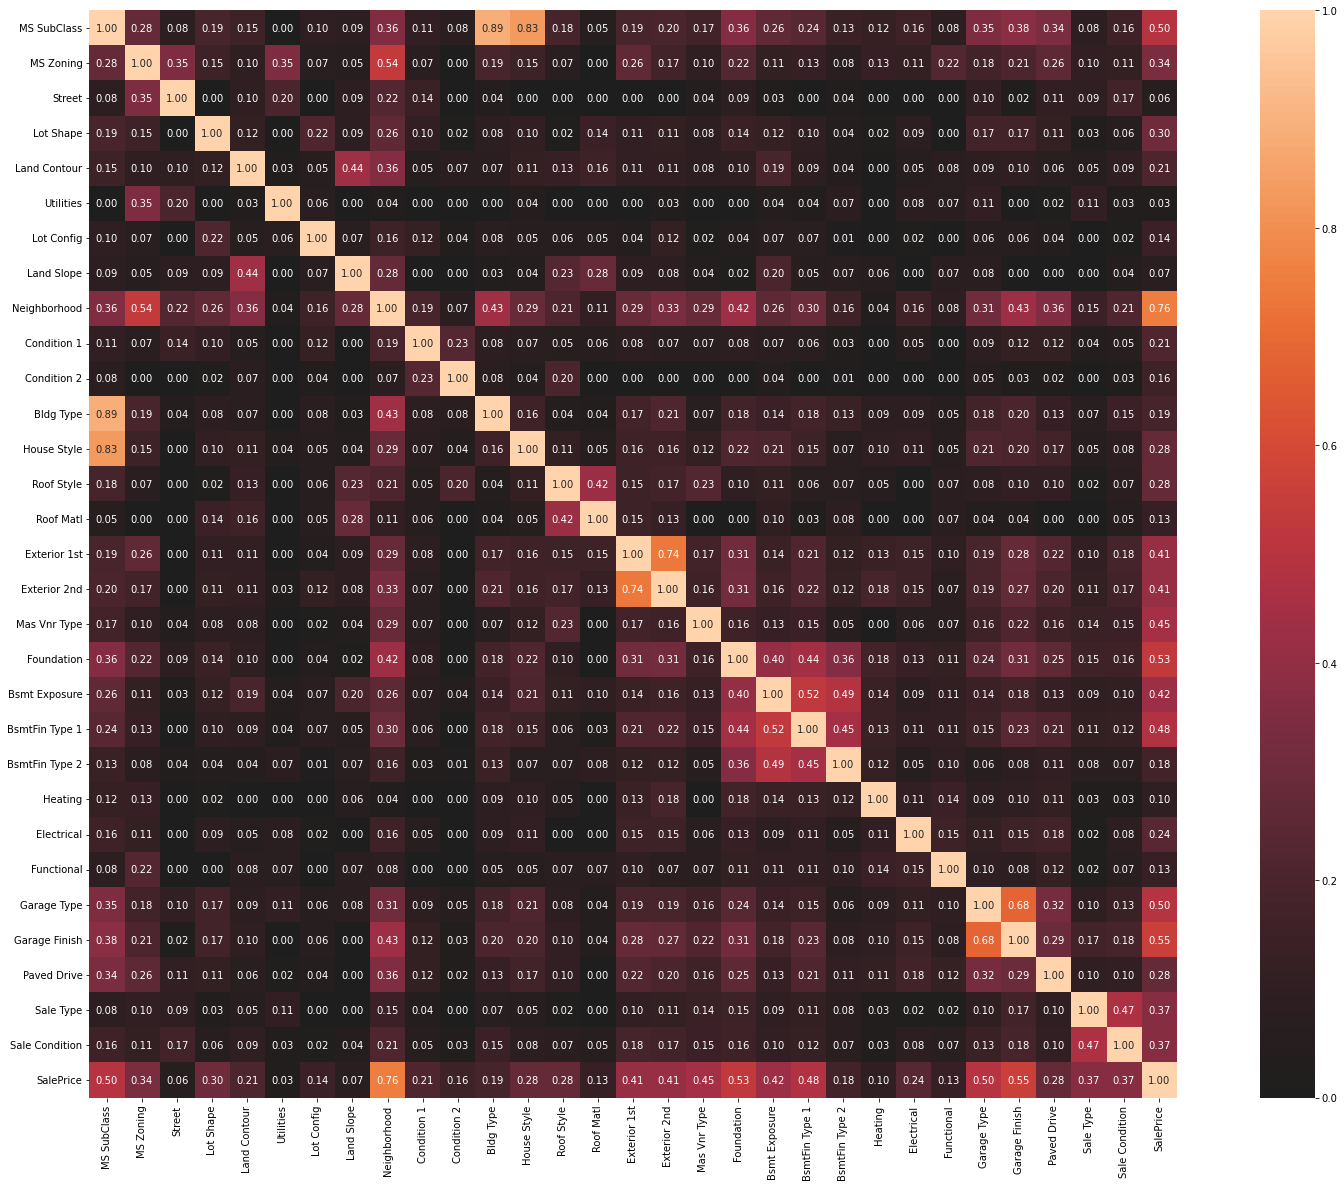

In [17]:
# Correlation for non-numeric variables
# Dython nominal.associations works well with object-type variables, may cause trouble with string-type variables
categorical.append(target)
corr_nom = nominal.associations(data[categorical],figsize=(30,20))
categorical.remove(target)

In [18]:
# Correlation of non-numeric data with target in descending order
category_correlations = corr_nom["corr"][target].sort_values(ascending=False)
print(category_correlations)

SalePrice         1.000000
Neighborhood      0.757151
Garage Finish     0.554700
Foundation        0.529272
Garage Type       0.498820
MS SubClass       0.497762
BsmtFin Type 1    0.477178
Mas Vnr Type      0.445932
Bsmt Exposure     0.424721
Exterior 1st      0.412103
Exterior 2nd      0.411566
Sale Type         0.373915
Sale Condition    0.370903
MS Zoning         0.340301
Lot Shape         0.302770
Roof Style        0.279362
House Style       0.278276
Paved Drive       0.276871
Electrical        0.242098
Condition 1       0.212481
Land Contour      0.209026
Bldg Type         0.185816
BsmtFin Type 2    0.175999
Condition 2       0.156105
Lot Config        0.144932
Functional        0.132555
Roof Matl         0.126682
Heating           0.098599
Land Slope        0.068563
Street            0.059519
Utilities         0.032503
Name: SalePrice, dtype: float64


In [19]:
# Removing non-numeric variables with correlation to target variable that is lower than parameter low_corr_category_param
# Warning: this might save some time for linear models, however you might lose significant information and not recommended 
# for non-linear approaches
for item in category_correlations[category_correlations < low_corr_category_parm].index:
    categorical.remove(item)
    
print('There are {} categorical variables left'.format(len(categorical)))

There are 14 categorical variables left


13 categorical variables will be considered for modeling purposes.  
In order to fit them into model we might consider target encoding, one-hot encoding or some other transformation.

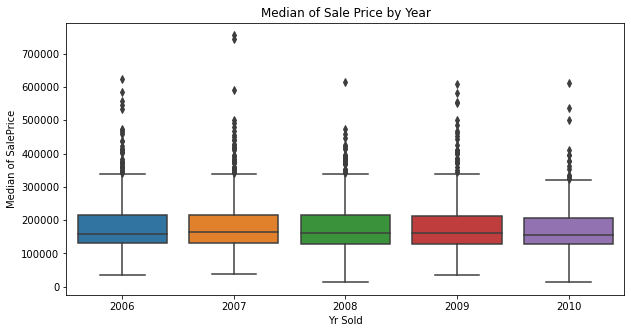

Yr Sold 
 5 unique values: 


,counts,percentage
2007,694,23.686007
2009,648,22.116041
2006,625,21.331058
2008,622,21.228669
2010,341,11.638225


In [20]:
#MANUAL_INPUT
var_boxplot(var = 'Yr Sold', data = data, target = target, title = 'Median of Sale Price by Year')

We can see that median sale price by ear of selling is more or less on the same level with slight decrease in 2008 (potentially because of subprime mortgage lending crisis), but recovering in upcoming years.

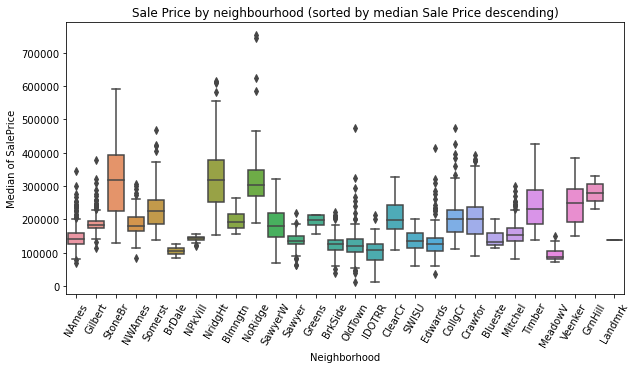

Neighborhood 
 28 unique values: 


,counts,percentage
NAmes,443,15.119454
CollgCr,267,9.112628
OldTown,239,8.156997
Edwards,194,6.621160
Somerst,182,6.211604
NridgHt,166,5.665529
Gilbert,165,5.631399
Sawyer,151,5.153584
NWAmes,131,4.470990
SawyerW,125,4.266212


In [21]:
#MANUAL_INPUT
var_boxplot(var =  "Neighborhood", data = data, target = target, 
            title = 'Sale Price by neighbourhood (sorted by median Sale Price descending)', xrotate = 60)

We can see that there is huge sale price variance based on neighbourhood with median price in the most expensive neighbourhood (Stone Br) more than 3x exceeding median price in the cheapest neighbourhood (Meadow V).

Small size categories have potential to be grouped together as "other" (reduce outlier influence).


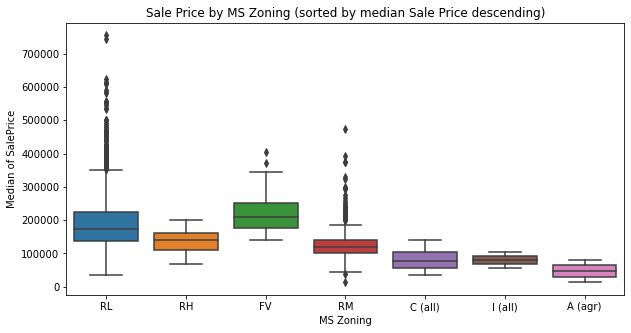

MS Zoning 
 7 unique values: 


,counts,percentage
RL,2273,77.576792
RM,462,15.767918
FV,139,4.744027
RH,27,0.921502
C (all),25,0.853242
I (all),2,0.068259
A (agr),2,0.068259


In [22]:
#MANUAL_INPUT
var_boxplot(var =  "MS Zoning", data = data, target = target, 
            title = 'Sale Price by MS Zoning (sorted by median Sale Price descending)')

High price differentiation based on MS Zoning, with most expensive zoning being:
1) Floating Village Residential  
2) Residential Low Density  
3) Residential High Density  
4) Residential Medium density  
5) Industrial  
6) Commercial  
7) Agricultural

Potential for grouping of less frequent categories ( C (all), I (all), A (agr) )

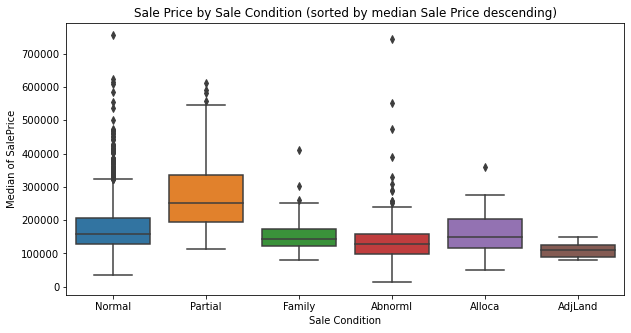

Sale Condition 
 6 unique values: 


,counts,percentage
Normal,2413,82.354949
Partial,245,8.361775
Abnorml,190,6.484642
Family,46,1.569966
Alloca,24,0.819113
AdjLand,12,0.409556


In [23]:
#MANUAL_INPUT
var_boxplot(var =  "Sale Condition", data = data, target = target, 
            title = 'Sale Price by Sale Condition (sorted by median Sale Price descending)')

Highest prices are associated with selling new houses (Partial), followed by normal sale type (Normal) and condo sale (Allocation).

Potential for joining Adjoining Land Purchases ('AdjLand') and Sale between family members ('Family') categories.

### 2.2 Numeric data

In [24]:
# find numerical variables
numerical = [var for var in data.columns if data[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

There are 48 numerical variables


In [25]:
discrete = []
for var in numerical:
    if len(data[var].unique())< levels_discrete:
        print(var, ' values: ', data[var].unique())
        discrete.append(var)
        
print('There are {} discrete variables'.format(len(discrete)))

Overall Qual  values:  [ 6  5  7  8  9  4  3  2 10  1]
Overall Cond  values:  [5 6 7 2 8 4 9 3 1]
Exter Qual  values:  [3 4 5 2]
Exter Cond  values:  [3 4 2 1 5]
Bsmt Qual  values:  [3 4 5 0 2 1]
Bsmt Cond  values:  [4 3 0 1 2 5]
Heating QC  values:  [2 3 5 4 1]
Central Air  values:  [1 0]
Bsmt Full Bath  values:  [ 1.  0.  2.  3. nan]
Bsmt Half Bath  values:  [ 0.  1. nan  2.]
Full Bath  values:  [1 2 3 0 4]
Half Bath  values:  [0 1 2]
Bedroom AbvGr  values:  [3 2 1 4 6 5 0 8]
Kitchen AbvGr  values:  [1 2 3 0]
Kitchen Qual  values:  [3 4 5 2 1]
TotRms AbvGrd  values:  [ 7  5  6  8  4 12 10 11  9  3 13  2 15 14]
Fireplaces  values:  [2 0 1 3 4]
Fireplace Qu  values:  [4 0 3 1 5 2]
Garage Cars  values:  [ 2.  1.  3.  0.  4.  5. nan]
Garage Qual  values:  [3 0 2 4 5 1]
Garage Cond  values:  [3 0 2 4 5 1]
Pool Area  values:  [  0 144 480 576 555 368 444 228 561 519 648 800 512 738]
Mo Sold  values:  [ 5  6  4  3  1  2  7 10  8 11  9 12]
Yr Sold  values:  [2010 2009 2008 2007 2006]
There a

In [26]:
# first we make a list of continuous variables (from the numerical ones)
temp_list = []
for item in ID_vars:
    temp_list.append(item)

continuous = [var for var in numerical if var not in discrete and var not in temp_list]
continuous

['Lot Frontage',
 'Lot Area',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Garage Yr Blt',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Misc Val',
 'SalePrice']

#### Numeric variables - Missing values handling
Usually this would be done on train & valid dataset only, excluding test/holdout data in order to prevent information leakage. However because of using mode value for missing data I am relaxing this requirement under assumption that train/valid and test data variable values distribution is similar.

In [27]:
data_transformed = transform_features(data_in = data)

Order - 0.0% of missing values. Variable copied.
PID - 0.0% of missing values. Variable copied.
Lot Frontage - 16.7235% of missing values. Variable copied.
Lot Area - 0.0% of missing values. Variable copied.
Overall Qual - 0.0% of missing values. Variable copied.
Overall Cond - 0.0% of missing values. Variable copied.
Year Built - 0.0% of missing values. Variable copied.
Year Remod/Add - 0.0% of missing values. Variable copied.
Mas Vnr Area - 0.785% of missing values. They are replaced with mode value - 0.0
Mas Vnr Area_NA is created to indicate missing values of original variable.
Exter Qual - 0.0% of missing values. Variable copied.
Exter Cond - 0.0% of missing values. Variable copied.
Bsmt Qual - 0.0% of missing values. Variable copied.
Bsmt Cond - 0.0% of missing values. Variable copied.
BsmtFin SF 1 - 0.0341% of missing values. They are replaced with mode value - 0.0
BsmtFin SF 1_NA is created to indicate missing values of original variable.
BsmtFin SF 2 - 0.0341% of missing value

In [28]:
#MANUAL_INPUT
# Check Garage Cars and Garage Area - mode imputation seems to be invalid here
print('Data inconsistencies: Checking automatic fill for missing values in Garage Cars and Garage Area')
display(HTML(data_transformed[(data_transformed['Garage Cars_NA']==1) | (data_transformed['Garage Area_NA']==1)].to_html()))
print('2 Garage cars and no garage, does not make much sense. I will change Garage Cars value to 0')
data_transformed.loc[data_transformed['Garage Cars_NA'] == 1, 'Garage Cars'] = 0
print(data_transformed[["Garage Cars","Order"]][data_transformed['Garage Cars_NA']==1])

Data inconsistencies: Checking automatic fill for missing values in Garage Cars and Garage Area


,Order,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area_NA,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,BsmtFin SF 1_NA,BsmtFin SF 1,BsmtFin SF 2_NA,BsmtFin SF 2,Bsmt Unf SF_NA,Bsmt Unf SF,Total Bsmt SF_NA,Total Bsmt SF,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath_NA,Bsmt Full Bath,Bsmt Half Bath_NA,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Cars_NA,Garage Cars,Garage Area_NA,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS SubClass,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Electrical,Functional,Garage Type,Garage Finish,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
2236,2237,910201180,50.0,9060,5,6,1923,1999,0,0.0,3,3,4,3,0,548.0,0,0.0,0,311.0,0,859.0,5,1,942,886,0,1828,0,0.0,0,0.0,2,0,3,1,4,6,0,0,NaN,1,2.0,1,0.0,0,0,174,0,212,0,0,0,0,3,2007,150909,C70,RM,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Plywood,None,BrkTil,No,ALQ,Unf,GasA,SBrkr,Typ,Detchd,Missing,Y,Missing,MnPrv,Missing,WD,Alloca


2 Garage cars and no garage, does not make much sense. I will change Garage Cars value to 0
      Garage Cars  Order
2236          0.0   2237


In [29]:
data_transformed.head()

,Order,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area_NA,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,BsmtFin SF 1_NA,BsmtFin SF 1,BsmtFin SF 2_NA,BsmtFin SF 2,Bsmt Unf SF_NA,Bsmt Unf SF,Total Bsmt SF_NA,Total Bsmt SF,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath_NA,Bsmt Full Bath,Bsmt Half Bath_NA,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Cars_NA,Garage Cars,Garage Area_NA,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS SubClass,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Electrical,Functional,Garage Type,Garage Finish,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
0,1,526301100,141.0,31770,6,5,1960,1960,0,112.0,3,3,3,4,0,639.0,0,0.0,0,441.0,0,1080.0,2,1,1656,0,0,1656,0,1.0,0,0.0,1,0,3,1,3,7,2,4,1960.0,0,2.0,0,528.0,3,3,210,62,0,0,0,0,0,5,2010,215000,C20,RL,Pave,Missing,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,Plywood,Stone,CBlock,Gd,BLQ,Unf,GasA,SBrkr,Typ,Attchd,Fin,P,Missing,Missing,Missing,WD,Normal
1,2,526350040,80.0,11622,5,6,1961,1961,0,0.0,3,3,3,3,0,468.0,0,144.0,0,270.0,0,882.0,3,1,896,0,0,896,0,0.0,0,0.0,1,0,2,1,3,5,0,0,1961.0,0,1.0,0,730.0,3,3,140,0,0,0,120,0,0,6,2010,105000,C20,RH,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,CBlock,No,Rec,LwQ,GasA,SBrkr,Typ,Attchd,Unf,Y,Missing,MnPrv,Missing,WD,Normal
2,3,526351010,81.0,14267,6,6,1958,1958,0,108.0,3,3,3,3,0,923.0,0,0.0,0,406.0,0,1329.0,3,1,1329,0,0,1329,0,0.0,0,0.0,1,1,3,1,4,6,0,0,1958.0,0,1.0,0,312.0,3,3,393,36,0,0,0,0,12500,6,2010,172000,C20,RL,Pave,Missing,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,CBlock,No,ALQ,Unf,GasA,SBrkr,Typ,Attchd,Unf,Y,Missing,Missing,Gar2,WD,Normal
3,4,526353030,93.0,11160,7,5,1968,1968,0,0.0,4,3,3,3,0,1065.0,0,0.0,0,1045.0,0,2110.0,5,1,2110,0,0,2110,0,1.0,0,0.0,2,1,3,1,5,8,2,3,1968.0,0,2.0,0,522.0,3,3,0,0,0,0,0,0,0,4,2010,244000,C20,RL,Pave,Missing,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,BrkFace,None,CBlock,No,ALQ,Unf,GasA,SBrkr,Typ,Attchd,Fin,Y,Missing,Missing,Missing,WD,Normal
4,5,527105010,74.0,13830,5,5,1997,1998,0,0.0,3,3,4,3,0,791.0,0,0.0,0,137.0,0,928.0,4,1,928,701,0,1629,0,0.0,0,0.0,2,1,3,1,3,6,1,3,1997.0,0,2.0,0,482.0,3,3,212,34,0,0,0,0,0,3,2010,189900,C60,RL,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,No,GLQ,Unf,GasA,SBrkr,Typ,Attchd,Fin,Y,Missing,MnPrv,Missing,WD,Normal


In [30]:
#MANUAL_INPUT
print('Data inconsistencies: checking if there are any sale records with date of refubrishment later than date of sale')
display(HTML(data_transformed[data_transformed["Yr Sold"]<data_transformed["Year Remod/Add"]].to_html()))

print('Data inconsistencies: checking if there are any sale records with date of construction later than date of sale')
display(HTML(data_transformed[data_transformed["Yr Sold"]<data_transformed["Year Built"]].to_html()))

print('All 3 (obs 2810 appears in both cases) observations contain data "from the future" (past point of sale), so we will delete them')
data_transformed = data_transformed.drop(data_transformed.index[[1702, 2180, 2181]])

Data inconsistencies: checking if there are any sale records with date of refubrishment later than date of sale


,Order,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area_NA,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,BsmtFin SF 1_NA,BsmtFin SF 1,BsmtFin SF 2_NA,BsmtFin SF 2,Bsmt Unf SF_NA,Bsmt Unf SF,Total Bsmt SF_NA,Total Bsmt SF,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath_NA,Bsmt Full Bath,Bsmt Half Bath_NA,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Cars_NA,Garage Cars,Garage Area_NA,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS SubClass,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Electrical,Functional,Garage Type,Garage Finish,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
1702,1703,528120010,134.0,16659,8,5,2007,2008,0,0.0,4,3,4,3,0,0.0,0,0.0,0,1582.0,0,1582.0,5,1,1582,570,0,2152,0,0.0,0,0.0,2,1,3,1,4,7,1,4,2007.0,0,2.0,0,728.0,3,3,0,368,0,0,0,0,0,6,2007,260116,C60,RL,Pave,Missing,IR1,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,No,Unf,Unf,GasA,SBrkr,Typ,Detchd,Unf,Y,Missing,Missing,Missing,New,Partial
2180,2181,908154195,128.0,39290,10,5,2008,2009,0,1224.0,5,3,5,3,0,4010.0,0,0.0,0,1085.0,0,5095.0,5,1,5095,0,0,5095,0,1.0,0,1.0,2,1,2,1,5,15,2,4,2008.0,0,3.0,0,1154.0,3,3,546,484,0,0,0,0,17000,10,2007,183850,C20,RL,Pave,Missing,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,Hip,CompShg,CemntBd,CmentBd,Stone,PConc,Gd,GLQ,Unf,GasA,SBrkr,Typ,Attchd,Fin,Y,Missing,Missing,Elev,New,Partial
2181,2182,908154205,130.0,40094,10,5,2007,2008,0,762.0,5,3,5,3,0,2260.0,0,0.0,0,878.0,0,3138.0,5,1,3138,1538,0,4676,0,1.0,0,0.0,3,1,3,1,5,11,1,4,2007.0,0,3.0,0,884.0,3,3,208,406,0,0,0,0,0,10,2007,184750,C60,RL,Pave,Missing,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,Hip,CompShg,CemntBd,CmentBd,Stone,PConc,Gd,GLQ,Unf,GasA,SBrkr,Typ,BuiltIn,Fin,Y,Missing,Missing,Missing,New,Partial


Data inconsistencies: checking if there are any sale records with date of construction later than date of sale


,Order,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area_NA,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,BsmtFin SF 1_NA,BsmtFin SF 1,BsmtFin SF 2_NA,BsmtFin SF 2,Bsmt Unf SF_NA,Bsmt Unf SF,Total Bsmt SF_NA,Total Bsmt SF,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath_NA,Bsmt Full Bath,Bsmt Half Bath_NA,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Cars_NA,Garage Cars,Garage Area_NA,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS SubClass,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Electrical,Functional,Garage Type,Garage Finish,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
2180,2181,908154195,128.0,39290,10,5,2008,2009,0,1224.0,5,3,5,3,0,4010.0,0,0.0,0,1085.0,0,5095.0,5,1,5095,0,0,5095,0,1.0,0,1.0,2,1,2,1,5,15,2,4,2008.0,0,3.0,0,1154.0,3,3,546,484,0,0,0,0,17000,10,2007,183850,C20,RL,Pave,Missing,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,Hip,CompShg,CemntBd,CmentBd,Stone,PConc,Gd,GLQ,Unf,GasA,SBrkr,Typ,Attchd,Fin,Y,Missing,Missing,Elev,New,Partial


All 3 (obs 2810 appears in both cases) observations contain data "from the future" (past point of sale), so we will delete them


### 2.3 New variables

In [31]:
#MANUAL_INPUT
#Variables that we can compute without risk of information leak
data_transformed["years_until_remod"] = data_transformed["Year Remod/Add"] - data_transformed["Year Built"]
data_transformed["years_remod_to_sale"]  = data_transformed["Yr Sold"] - data_transformed["Year Remod/Add"]
data_transformed["years_built_to_sale"]  = data_transformed["Yr Sold"] - data_transformed["Year Built"]

data_transformed["sin_month_sale"] = data_transformed["Mo Sold"].apply(lambda x: math.sin(2*np.pi*float(x)/12)) # seasonality 
data_transformed["cos_month_sale"] = data_transformed["Mo Sold"].apply(lambda x: math.cos(2*np.pi*float(x)/12)) # seasonality 

data_transformed["Bathroom_total"] = data_transformed["Bsmt Full Bath"].fillna(0) + data_transformed["Bsmt Half Bath"].fillna(0) + data_transformed["Full Bath"].fillna(0) + data_transformed["Half Bath"].fillna(0)
data_transformed["Floor_area"] = data_transformed["Gr Liv Area"] + data_transformed["Garage Area"] + data_transformed["Total Bsmt SF"]
data_transformed["Floor_area_ratio"] = data_transformed["Floor_area"] / data_transformed["Lot Area"]

# Variable list clean-up
for var in ["years_until_remod", "years_remod_to_sale", "years_built_to_sale", "Floor_area", 
            "Lot Area", "Floor_area_ratio"]:
    try:
        continuous.append(var)
    except:
        print(var,'is already added to the continuous list.')
           
for var in ["cos_month_sale", "sin_month_sale", "Bathroom_total"]:
    try:
        discrete.append(var)
    except:
        print(var,'is already added to the discrete list.')

for var in ["Year Remod/Add", "Year Built", "Garage Yr Blt"]:        
    try:
        continuous.remove(var)
    except:
        print(var,'is not in continuous list.')
        
for var in ["Yr Sold", "Mo Sold"]:
    try:
        discrete.remove(var)
    except:
        print(var,'is not in continuous list.')
                
data_transformed.describe(include = 'all')

,Order,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area_NA,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,BsmtFin SF 1_NA,BsmtFin SF 1,BsmtFin SF 2_NA,BsmtFin SF 2,Bsmt Unf SF_NA,Bsmt Unf SF,Total Bsmt SF_NA,Total Bsmt SF,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath_NA,Bsmt Full Bath,Bsmt Half Bath_NA,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Cars_NA,Garage Cars,Garage Area_NA,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS SubClass,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Electrical,Functional,Garage Type,Garage Finish,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition,years_until_remod,years_remod_to_sale,years_built_to_sale,sin_month_sale,cos_month_sale,Bathroom_total,Floor_area,Floor_area_ratio
count,2927.000000,2.927000e+03,2437.000000,2927.000000,2927.000000,2927.000000,2927.00000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2768.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927,2927.000000,2927.000000,2927.000000,2.927000e+03,2.927000e+03,2927.000000,2927.000000,2927.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,7,2,3,4,4,3,5,3,28,9,8,5,8,6,8,16,17,6,6,5,7,7,6,6,8,7,4,3,5,5,5,10,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C20,RL,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,No,GLQ,Unf,GasA,SBrkr,Typ,Attchd,Unf,Y,Missing,Missing,Missing,WD,Normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1078,2270,2915,2729,1859,2632,2924,2138,2786,443,2520,2898,2422,1480,2320,2884,1025,1014,1751,1307,1905,857,2496,2882,2679,2725,1730,1230,2649,2914,2355,2822,2536,2413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1464.929621,7.143958e+08,69.148954,10125.510079,6.091561,5.563717,1971.31944,1984.241886,0.007858,100.522036,3.397335,3.085412,3.477622,2.922788,0.000342,440.789887,0.000342,49.756406,0.000342,558.433550,0.000342,1048.979843,4.148616,0.933037,1157.392894,335.079604,4.681585,1497.154083,0.000683,0.430817,0.000683,0.060813,1.565767,0.378886,2.854458,1.044414,3.510079,6.438333,0.598565,1.768022,1978.100795,0.000342,1.765289,0.000342,472.197813,2.801503,2.809361,93.590366,47.152374,23.035190,2.595149,16.018449,2.245644,44.879057,6.213529,2007.791254,180766.566450,NaN,NaN,NaN,NaN,Na

### 2.4 Data conversion

In [32]:
# Converting object types to numbers and strings
# Convert dtypes tends to convert to Float64 or Int64 type, which does not cooperate well with other libraries
# Therefore we convert in a loop to float64 type
# For further improvement we could differentiate between float and int variables
data = data.convert_dtypes()

for column in data.select_dtypes(include=['int']).columns:
    data[column] = data[column].astype(float)

# Check if conversion went smoothly
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   float64
 1   PID              2930 non-null   float64
 2   MS SubClass      2930 non-null   string 
 3   MS Zoning        2930 non-null   string 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   float64
 6   Street           2930 non-null   string 
 7   Alley            2930 non-null   string 
 8   Lot Shape        2930 non-null   string 
 9   Land Contour     2930 non-null   string 
 10  Utilities        2930 non-null   string 
 11  Lot Config       2930 non-null   string 
 12  Land Slope       2930 non-null   string 
 13  Neighborhood     2930 non-null   string 
 14  Condition 1      2930 non-null   string 
 15  Condition 2      2930 non-null   string 
 16  Bldg Type        2930 non-null   string 
 17  House Style   

## Train/Valid/Test split

In [33]:
# Preparing list of explanatory variables 
features = list(chain(continuous, categorical, discrete))

try:
    features.remove(target)
except:
    print('Variable',target,'is already removed from features list.')


# X - contains X and Y variable here
X = data_transformed.loc[:, features]
y = data_transformed[target]

# We split first to train_valid and test and then to train and valid separately, because we want to use tran_valid test 
# for crossvalidation purposes
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, random_state= seed, train_size = test_split)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, random_state= seed, train_size = valid_split)

In [34]:
print('X train size: ' + str(X_train.shape[0]))
print('X valid size: ' + str(X_valid.shape[0]))
print('X train_valid size: ' + str(X_train_valid.shape[0]))
print('X test (holdout) size: ' + str(X_test.shape[0]))
print('\n')
print('Y train size: ' + str(y_train.shape[0]))
print('Y valid size: ' + str(y_valid.shape[0]))
print('Y train_valid size: ' + str(y_train_valid.shape[0]))
print('Y test (holdout) size: ' + str(y_test.shape[0]))
print('\n')
print('Total data size: ' + str(data_transformed.shape[0]))
# Sample sizes are correct

X train size: 1872
X valid size: 469
X train_valid size: 2341
X test (holdout) size: 586


Y train size: 1872
Y valid size: 469
Y train_valid size: 2341
Y test (holdout) size: 586


Total data size: 2927


## EDA

In [35]:
totala = 0

for var in X_train_valid.select_dtypes(exclude=['category']):
    if np.isinf(X_train_valid[[var]]).sum().all() != 0:
        print(var,'has infinite values present.')
        totala += 1

if totala == 0:
    print('There are no infinite values in checked set of variables')

There are no infinite values in checked set of variables


In [36]:
#MANUAL_INPUT

# First - let's exclude low variance variables from our analysis
# We need to skip missing values or exclude variables with missing values - drop(['Lot Frontage'])
variable_input=X_train_valid.select_dtypes(exclude=['category'])
variable_input.drop(columns=['Lot Frontage'], inplace = True)

normalized_df=(variable_input-variable_input.min())/(variable_input.max()-variable_input.min()) # min-max scaling for <0;1> range of values
low_var = normalized_df.var()
low_var_columns = variable_input.columns

low_var_vars = [ ]

for i in range(0,len(low_var)):
    if low_var[i]<=0.005: #setting the threshold as 5%
        low_var_vars.append(str(low_var_columns[i]))
        print(str(low_var_columns[i])+ ' - ' + str(low_var[i]))

Lot Area - 0.0013257143209051317
Low Qual Fin SF - 0.0019458830582587635
Enclosed Porch - 0.0038537346458890555
3Ssn Porch - 0.0030666998737511127
Misc Val - 0.0009985590691309538
Lot Area - 0.0013257143209051317
Pool Area - 0.001942592527597069


In [37]:
#MANUAL_INPUT
#Deleting low variance variables (without variables that only indicate imputation)

temp_list = ["Bsmt Full Bath_NA","Bsmt Half Bath_NA "]
low_var_vars = [var for var in low_var_vars if var not in discrete and var not in temp_list]
low_var_vars


for var in low_var_vars:
    try:
        continuous.remove(var)
        features.remove(var)
    except:
        print(var,'is not in continuous or features list.')          

In [38]:
# Deleting target
try:
    continuous.remove(target)
    features.remove(target)
except:
    print(target,'is not in continuous or features list.')    

SalePrice is not in continuous or features list.


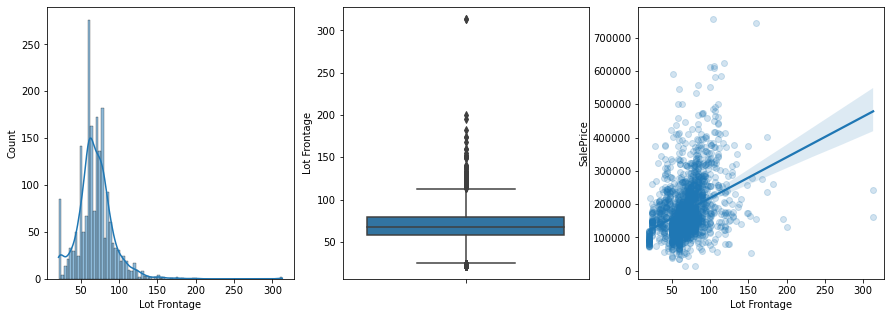

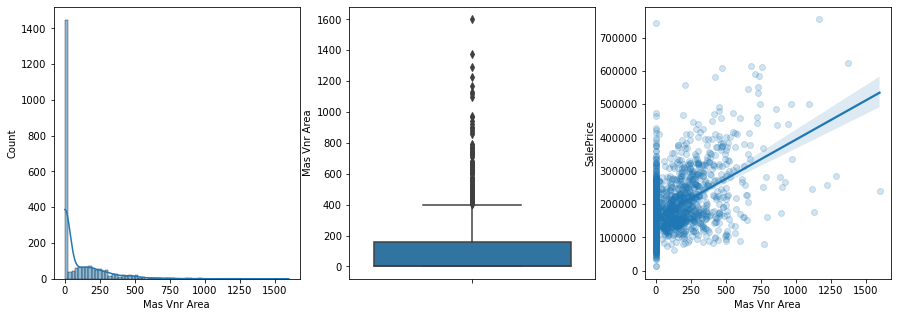

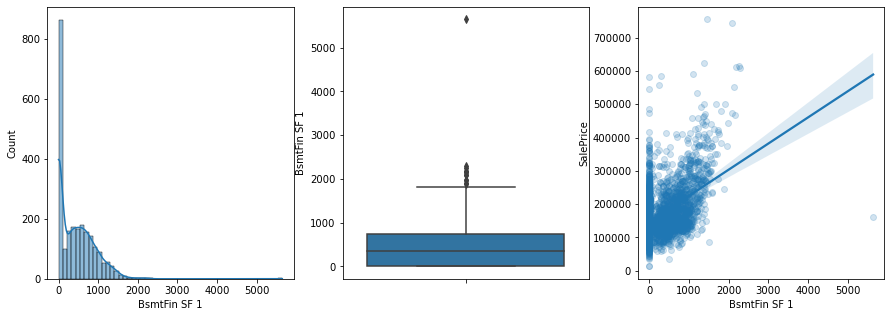

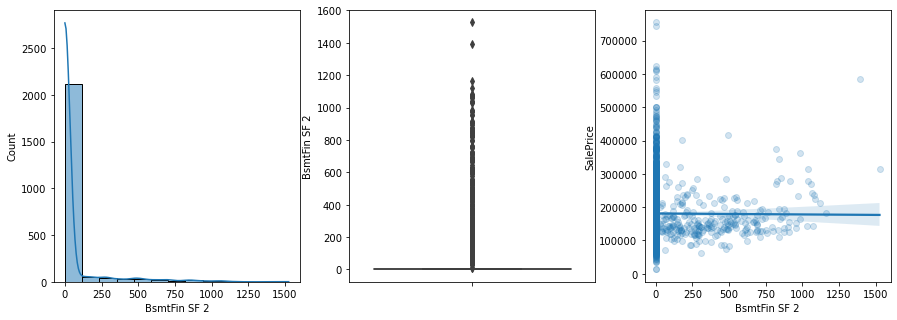

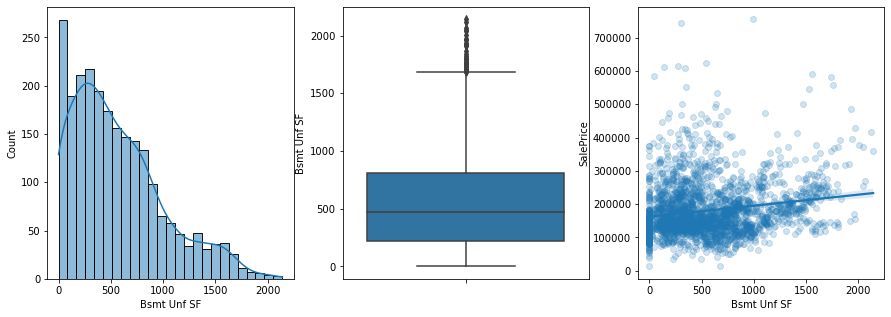

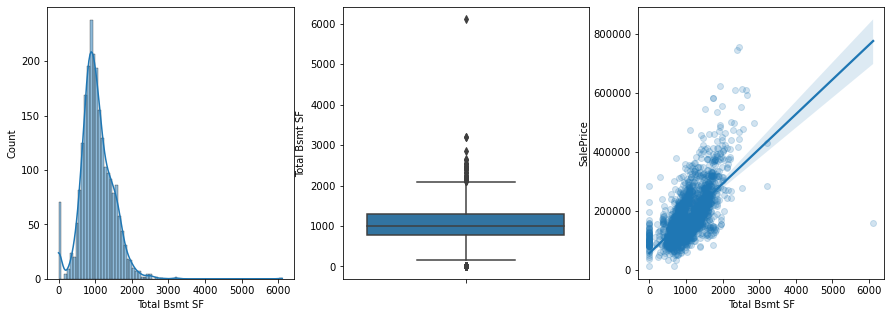

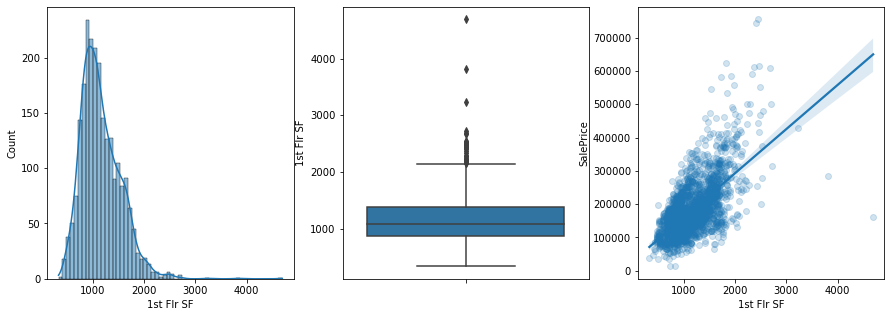

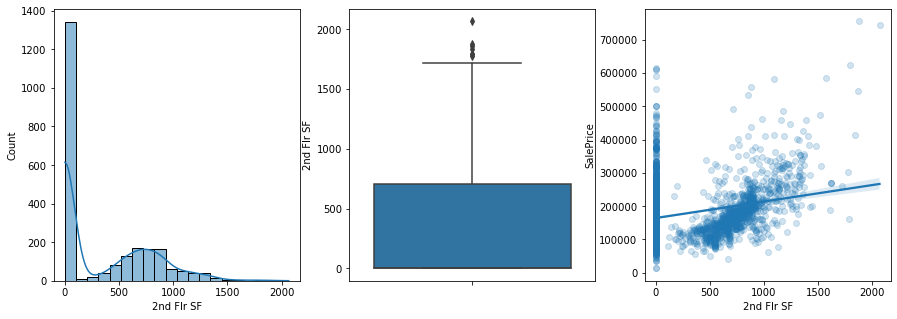

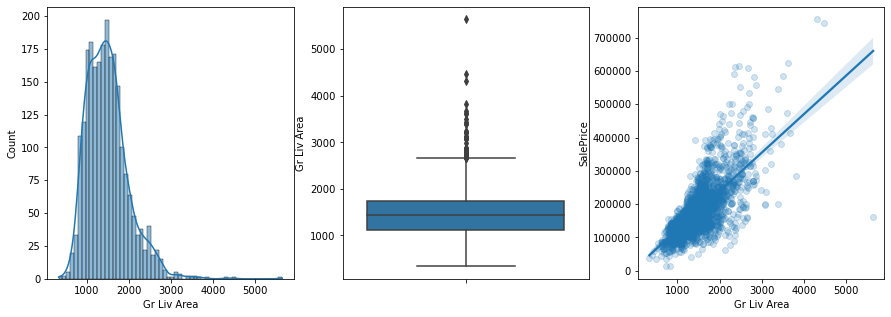

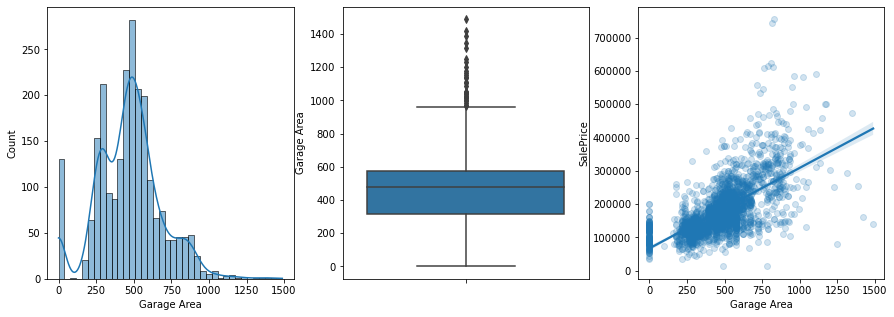

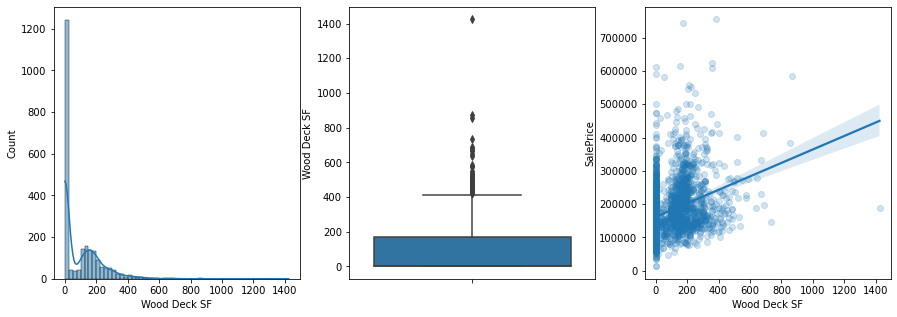

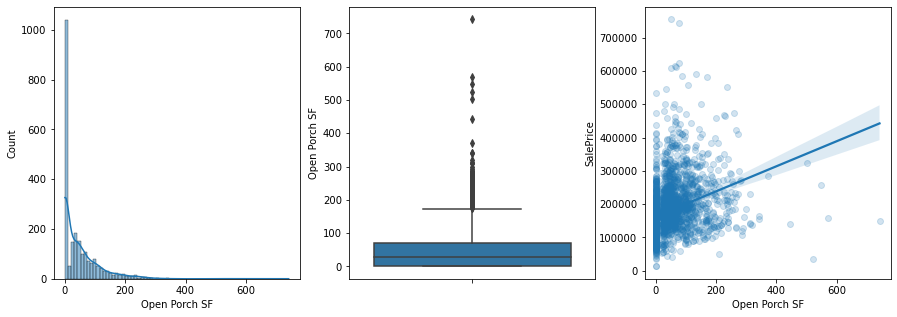

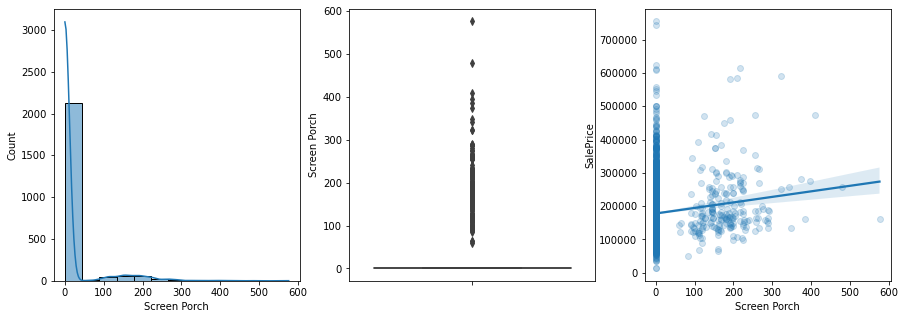

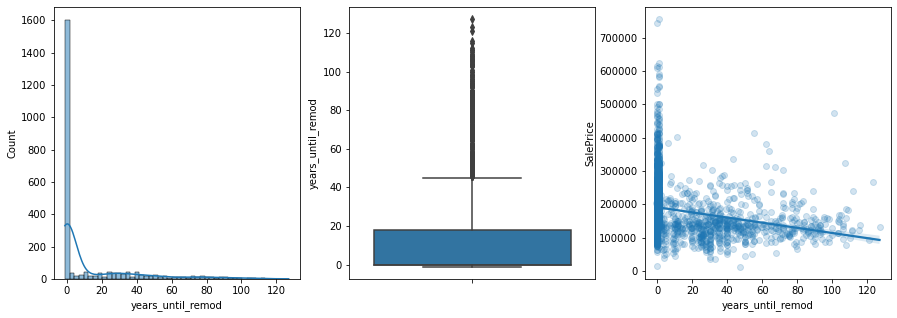

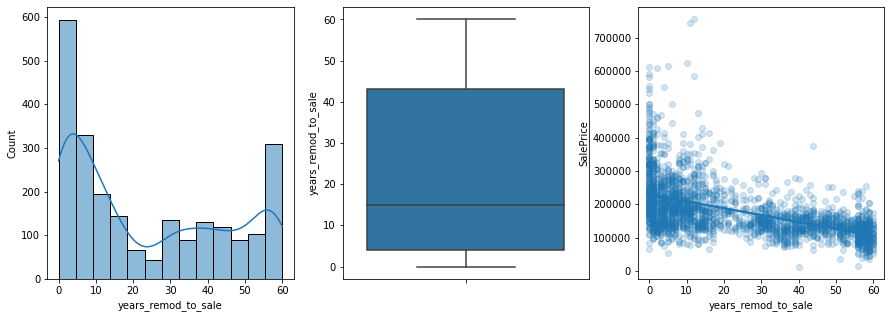

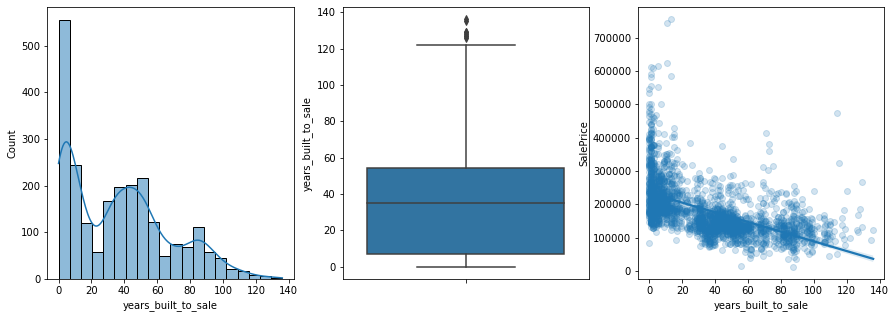

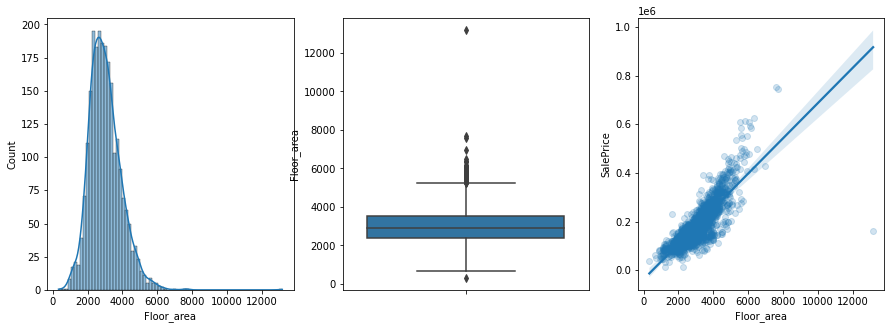

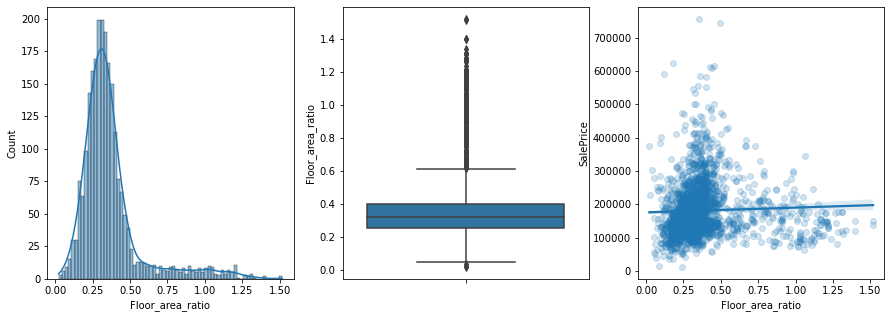

In [39]:
# Visual representation od independent variables

for var in continuous:
    fig,ax=plt.subplots(1,3,figsize=(15,5))
    sn.histplot(X_train_valid[var].dropna(), kde=True, ax=ax[0])
    sn.boxplot(y=X_train_valid[var], ax=ax[1])
    sn.regplot(data=X_train_valid, x=var, y=y_train_valid, scatter_kws={'alpha':0.2})
    plt.show()

In [40]:
# Visual representation of target variable

We can see that most of data is not coming from normal distribution. Also most of variables have lots of outliers. Transformation of independent variables is recommended.

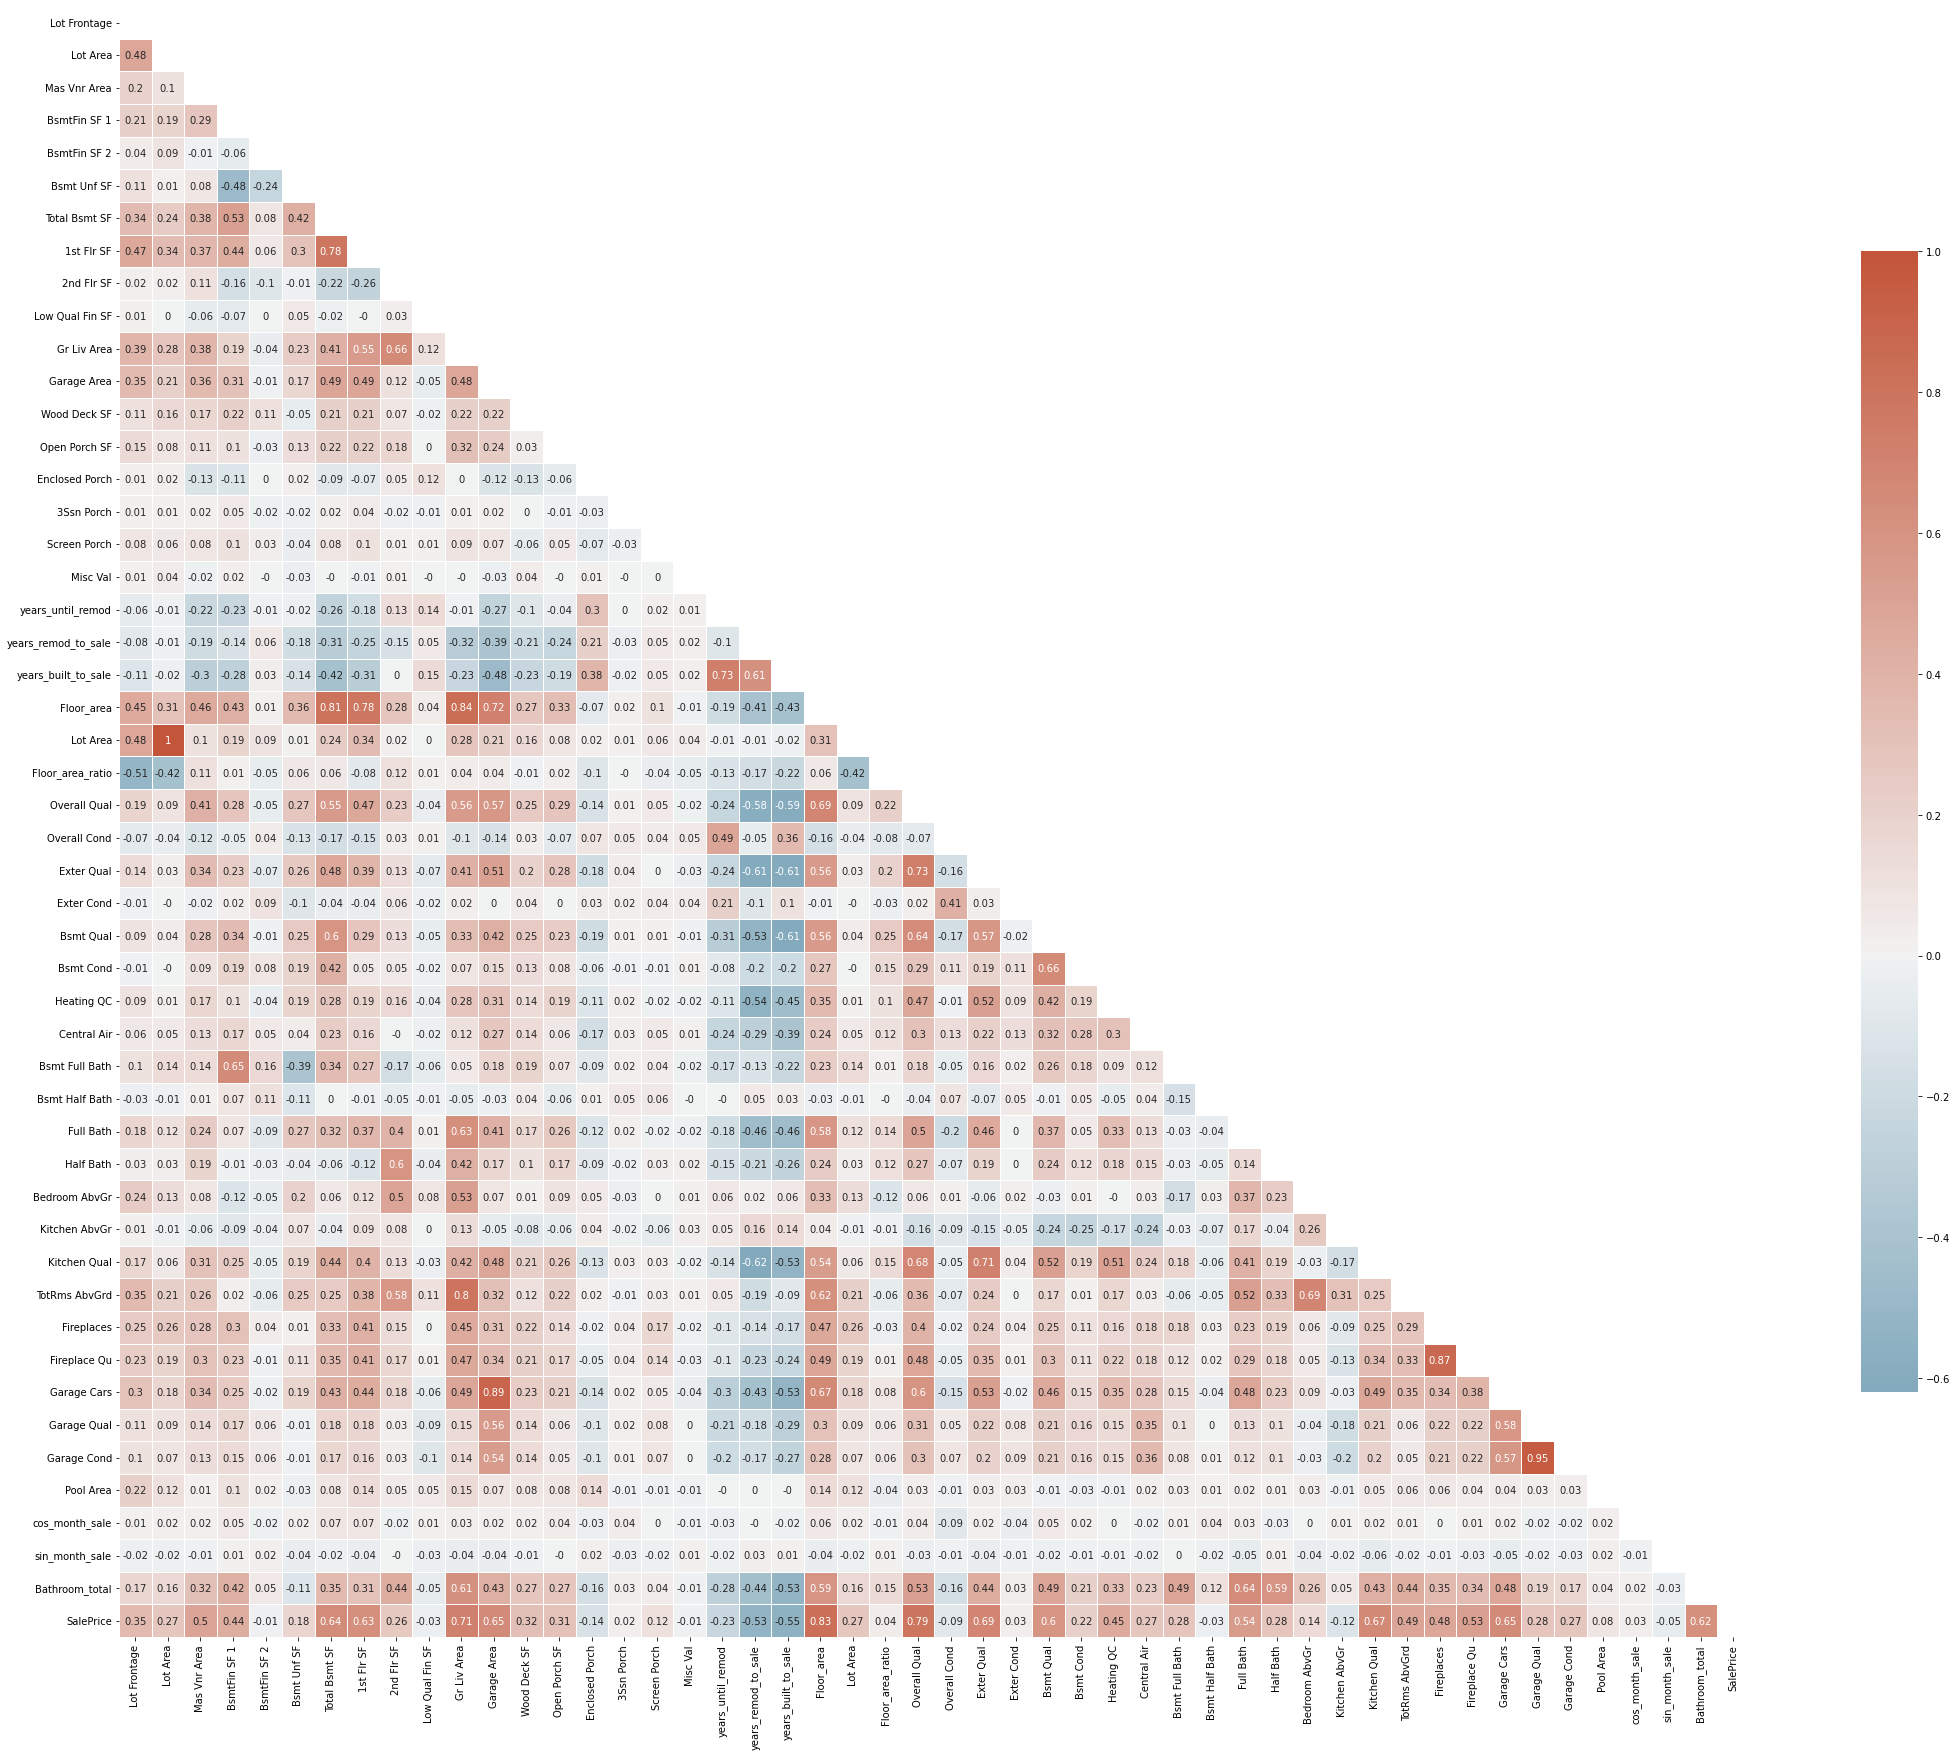

In [41]:
f, ax = plt.subplots(figsize=(40, 30))
mat = round(X_train_valid.merge(y_train_valid, left_index = True, right_index = True).corr('pearson'),2)
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sn.diverging_palette(230, 20, as_cmap=True)
sn.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.show()

In [42]:
# Finding potentially statistically significant (> abs(strong_correlation_param) ) Pearson correlations 
matrix = mat.where(np.triu(np.ones(mat.shape)).astype(bool))
strong_corr_df = matrix.stack().reset_index()
strong_corr_df.columns = ["Var1","Var2","Correlation"]
strong_corr_df["Correlation_abs"]=abs(strong_corr_df["Correlation"])
strong_corr_df.sort_values("Correlation_abs", inplace = True, ascending=False)
strong_corr_df = strong_corr_df[strong_corr_df["Var1"] != strong_corr_df["Var2"]] # removing correlations with self
strong_corr_df = strong_corr_df[strong_corr_df["Var1"].str.contains("_NA") == False] # removing correlations with dummy _NA variables
strong_corr_df = strong_corr_df[abs(strong_corr_df["Correlation"]) > strong_correlation_param]
print(str(strong_corr_df.shape[0]) + ' potentially statistically significant correlations')
strong_corr_df

6 potentially statistically significant correlations


,Var1,Var2,Correlation,Correlation_abs
1248,Garage Qual,Garage Cond,0.95,0.95
526,Garage Area,Garage Cars,0.89,0.89
1221,Fireplaces,Fireplace Qu,0.87,0.87
466,Gr Liv Area,Floor_area,0.84,0.84
868,Floor_area,SalePrice,0.83,0.83
300,Total Bsmt SF,Floor_area,0.81,0.81


We can observe multiple strong (>0.8 or < -0.8) correlations. Short summary:
* 1306 - Garage Quality seems strongly correlated with Garage Condition (both measured on a ordinal scale) - possibly they reflect same data, so one of those might be redundant
* 578 - Garage area is strongly correlated with number of cars that particular garage can store - obvious
* 1282 - number of fireplaces is connected with fireplace quality
* 478, 308 - living area and basement arera is connected to total floor area - yes because they are floor_area components
* 802 - Sale Price is strongly correlated with floor area - to be expected


Based on plot analysis we can see that logarithm of Sale Price is most similar to normal distribution. Having said that qqplot suggest heavy tails, so we should treat our sample for outliers.

# Target variable

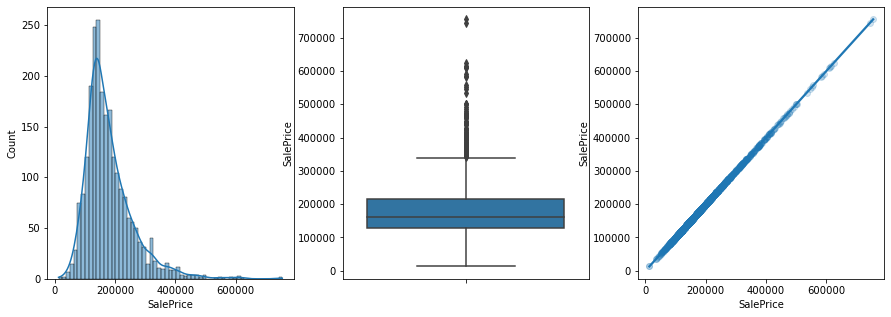

In [43]:
# Visual representation od target variable
fig,ax=plt.subplots(1,3,figsize=(15,5))
sn.histplot(y_train_valid, kde=True, ax=ax[0])
sn.boxplot(y=y_train_valid, ax=ax[1])
sn.regplot(data=y_train_valid, x=y_train_valid, y=y_train_valid, scatter_kws={'alpha':0.2})
plt.show()

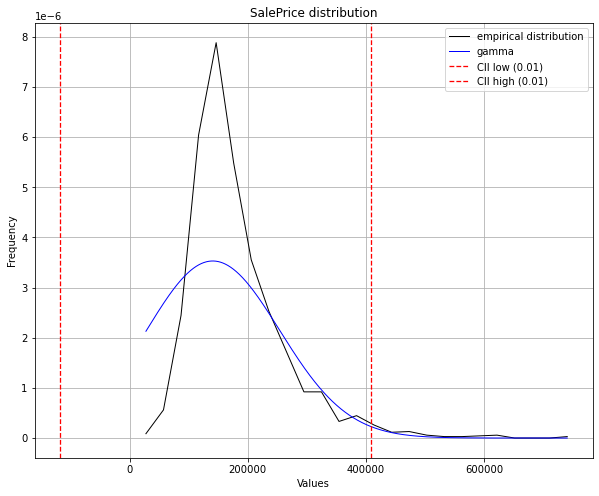

,distr,score,LLE,loc,scale,arg
0,gamma,0.322892,NaN,-7016805.354971,1783.334285,"(4014.5233941390547,)"
1,beta,0.322892,NaN,7335.064418,155909911703.94931,"(5.431475935138053, 4879097.4429438785)"
2,dweibull,0.545091,NaN,163682.763794,57811.135891,"(1.058311602631445,)"
3,norm,0.807543,NaN,180719.097821,80572.006724,()
4,t,0.807543,NaN,180720.244705,80572.248836,"(1968280.2058017654,)"
5,loggamma,0.807543,NaN,-26266591.114505,3512680.853273,"(1861.8036614516375,)"
6,expon,1.108472,NaN,12789.0,167930.097821,()
7,genextreme,1.108472,NaN,-7777.868228,281.508273,"(-5.514878125970636,)"
8,pareto,1.448411,NaN,-16.846476,12805.846432,"(0.3903550159054474,)"
9,lognorm,1.448411,NaN,12789.0,5.056262,"(10.888185136336912,)"


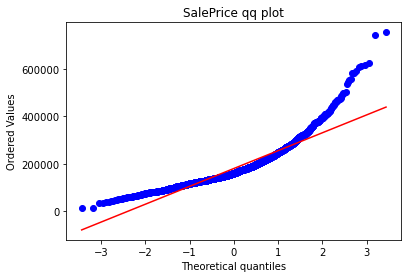

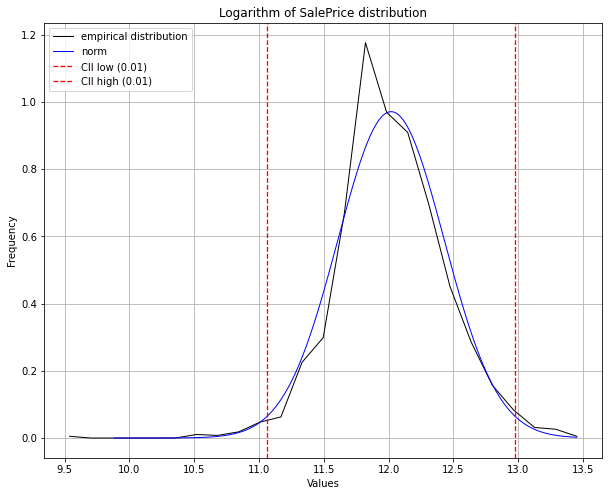

,distr,score,LLE,loc,scale,arg
0,norm,0.148617,NaN,12.019276,0.411007,()
1,dweibull,0.148617,NaN,12.021998,0.338299,"(1.224106082912213,)"
2,t,0.148617,NaN,12.013621,0.357673,"(8.30197525536093,)"
3,genextreme,0.148617,NaN,11.867267,0.424484,"(0.24402584764904311,)"
4,gamma,0.148617,NaN,-9.374715,0.007911,"(2704.4930277915464,)"
5,lognorm,0.148617,NaN,-42.005757,54.024241,"(0.0076125892600922875,)"
6,beta,0.148617,NaN,-311.402933,393.791521,"(110661.31973114412, 24077.385978174298)"
7,loggamma,0.148617,NaN,-83.075752,13.592104,"(1093.1314747500282,)"
8,expon,3.228419,NaN,9.456341,2.562935,()
9,pareto,3.228419,NaN,-0.016884,9.473225,"(4.185511367063793,)"


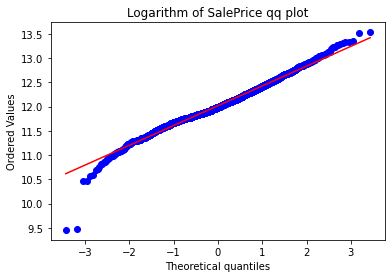

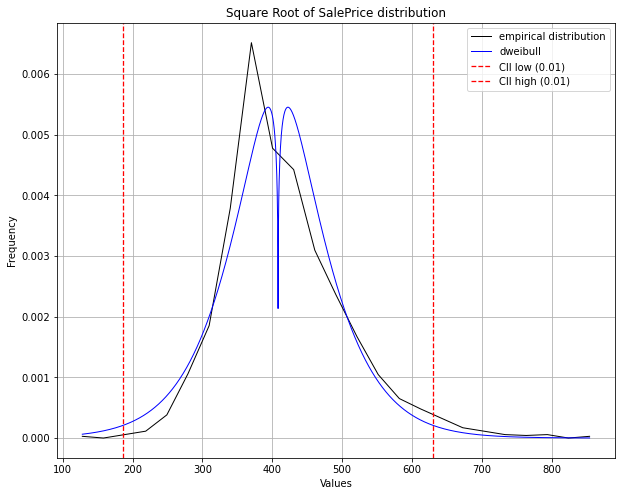

,distr,score,LLE,loc,scale,arg
0,dweibull,0.001945,NaN,408.174192,69.77583,"(1.1793494928336823,)"
1,t,0.001945,NaN,416.505352,87.502342,"(15.19811005021814,)"
2,norm,0.148617,NaN,416.045624,87.322029,()
3,genextreme,0.148617,NaN,379.548812,76.031496,"(0.09449925697872988,)"
4,gamma,0.148617,NaN,36.768537,19.271177,"(19.681054210050647,)"
5,lognorm,0.148617,NaN,-50.874345,459.174416,"(0.18211483258189326,)"
6,beta,0.148617,NaN,99.933471,969.847291,"(8.08777826986941, 16.711318156535867)"
7,loggamma,0.148617,NaN,-34141.460913,4425.881664,"(2460.722606645755,)"
8,expon,1.828622,NaN,113.088461,302.957163,()
9,pareto,1.828622,NaN,-0.159322,113.247781,"(0.7808419191970906,)"


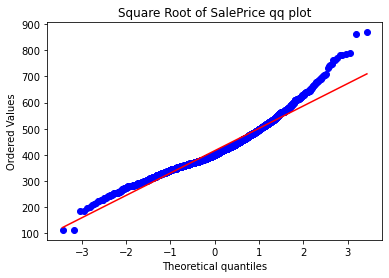

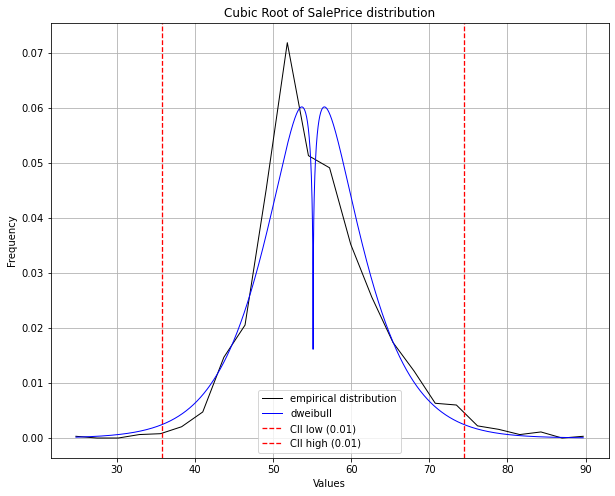

,distr,score,LLE,loc,scale,arg
0,dweibull,0.001945,NaN,55.110402,6.248435,"(1.2066210577961,)"
1,t,0.001945,NaN,55.530349,7.732257,"(21.104319304475112,)"
2,norm,0.038582,NaN,55.468366,7.667951,()
3,genextreme,0.038582,NaN,52.376954,7.121377,"(0.14660835331044386,)"
4,gamma,0.038582,NaN,5.346018,1.151714,"(43.51979723143563,)"
5,lognorm,0.038582,NaN,-8.525365,63.545002,"(0.11840091607642955,)"
6,beta,0.038582,NaN,10.27205,3854771.55627,"(34.756603848474676, 2963718.5540145086)"
7,loggamma,0.038582,NaN,-2288.671867,316.739203,"(1637.7912984632412,)"
8,expon,2.250696,NaN,23.385439,32.082927,()
9,pareto,2.250696,NaN,-0.060694,23.446133,"(1.1727186981853812,)"


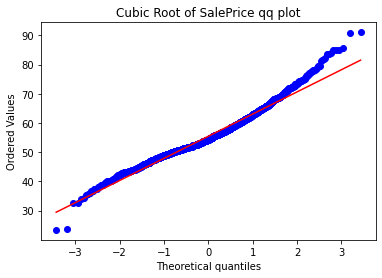

In [44]:
# Distribution fitting of target variable
# Check best fitted distribution to logarithm of target variable (variable is continuous so we suspect that logarithm
# will allow to smooth the effect of outliers, hence will be more similar to normal distribution)

for data_in, name in zip([y_train_valid, np.log(y_train_valid), np.sqrt(y_train_valid), y_train_valid**(1/3)],
                         [target,'Logarithm of ' + target,'Square Root of ' + target, 'Cubic Root of ' + target]):
    dist = distfit.distfit(bins=25,alpha=0.01,stats='ks')
    dist.fit_transform(data_in,verbose=1)
    dist.plot(verbose=1)
    plt.title(str(name) + ' distribution')
    plt.show()

    display(HTML(dist.summary.to_html()))

    stats.probplot(data_in, dist="norm", plot=pylab)
    pylab.title(str(name) + ' qq plot')
    pylab.show()

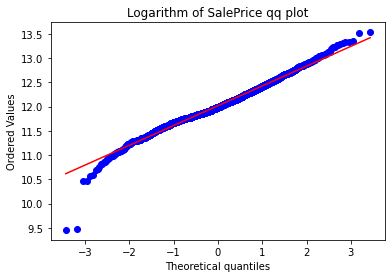

count    2341.000000
mean       12.019276
std         0.411095
min         9.456341
25%        11.771436
50%        11.982929
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64


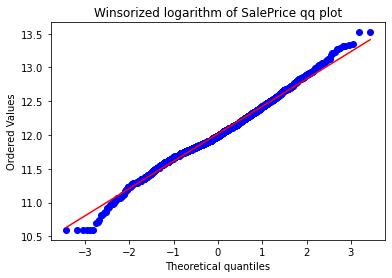

count    2341.000000
mean       12.020357
std         0.405935
min        10.596635
25%        11.771436
50%        11.982929
75%        12.273731
max        13.521139
dtype: float64


In [45]:
#MANUAL_INPUT
# Winsorizing target variable to limit outlier values impact
y2_train_valid = pd.Series(mstats.winsorize(np.log(y_train_valid), limits=[0.0025, 0.0008]))

stats.probplot(np.log(y_train_valid), dist="norm", plot=pylab)
pylab.title('Logarithm of ' + target + ' qq plot')
pylab.show()
print(np.log(y_train_valid).describe())

stats.probplot(y2_train_valid, dist="norm", plot=pylab)
pylab.title('Winsorized logarithm of ' + target + ' qq plot')
pylab.show()
print(y2_train_valid.describe())

QQ-plot characteristics seems to improve slightly after winsorizing target variable. We will try to estimate our model on both versions of target variables and see which performs better.

### Further feature engineering - optimal binning and WoE transformation

In [46]:
# 2022-01-20 - fill function definitions in function declaration

In [47]:
# Create optimal bins for Weight of Evidence Feature Engineering for categorical variables
data_optbin = Optbin_create(X_df = X_train_valid, y = y_train_valid, var_list = categorical)

int64 float64
MS SubClass - IV suggests weak predictive power -  0.048453082697434674
int64 float64
MS Zoning - IV suggests weak predictive power -  0.024929548350793043
int64 float64
Lot Shape - IV suggests not useful for prediction -  0.01796345085400489
int64 float64
Neighborhood - IV suggests weak predictive power -  0.09831971586064954
int64 float64
Exterior 1st - IV suggests weak predictive power -  0.03238246939274324
int64 float64
Exterior 2nd - IV suggests weak predictive power -  0.031084655560948714
int64 float64
Mas Vnr Type - IV suggests weak predictive power -  0.03081923540438754
int64 float64
Foundation - IV suggests not useful for prediction -  0.01622804475246063
Bsmt Exposure - IV suggests weak predictive power -  0.02721169022089578
BsmtFin Type 1 - IV suggests weak predictive power -  0.024995599695328934
int64 float64
Garage Type - IV suggests weak predictive power -  0.049449498055573846
Garage Finish - IV suggests weak predictive power -  0.056567047790837675
in

In [48]:
# WoE transformation for categorical variables
for i in categorical :
    X_train_valid["WOE_"+i] = VarTransform(data = X_train_valid, var_name = i, optbin_dict = data_optbin)
    

In [49]:
print(data_optbin["Garage Type"]["bin_table"])
print(X_train_valid[["WOE_Garage Type","Garage Type"]].drop_duplicates(subset=["WOE_Garage Type","Garage Type"], keep='first'))

                      Bin  Count  Count (%)          Sum           Std  \
0               [Missing]    130   0.055532   13536983.0  32195.878066   
1       [Detchd, Basment]    653   0.278941   87495693.0  42340.759286   
2       [Attchd, BuiltIn]   1527   0.652285  317811523.0  82711.199436   
3       [2Types, CarPort]     31   0.013242    4219209.0  39465.581574   
4                 Special      0   0.000000          0.0           NaN   
5                 Missing      0   0.000000          0.0           NaN   
Totals                      2341   1.000000  423063408.0                 

                 Mean      Min       Max  Zeros count       WoE        IV  
0       104130.638462  34900.0  200500.0            0 -0.551298  0.012974  
1       133990.341501  12789.0  475000.0            0 -0.299176  0.021578  
2       208128.043877  13100.0  755000.0            0  0.141210  0.013970  
3       136103.516129  71000.0  235000.0            0 -0.283528  0.000927  
4            0.000000      

In [ ]:
from category_encoders import TargetEncoder
data2=train_valid[["MS SubClass", 'MS Zoning', target]]
enc1=TargetEncoder()
data2 = enc1.fit_transform(data2[["MS SubClass",'MS Zoning']], data2[target])

In [ ]:
#Normalizing explanatory variables using MinMax Scaler

train_scaler = MinMaxScaler()
train_valid[continuous] = train_scaler.fit_transform(train_valid[continuous])

In [ ]:
train_valid[continuous].describe()

In [ ]:
features

## Linear Regression

In [ ]:
def select_features(data):

    return ["Gr Liv Area","SalePrice"]

In [ ]:
def train_and_test(data, target):
    train = data[:1460]
    test = data[1460:]
    features = select_features(train)
    features.remove(target)
    reg = LinearRegression()
    reg.fit(train[features], train[target])
    predictions=reg.predict(test[features])
    rmse=np.sqrt(mean_squared_error(predictions,test[target]))
    return rmse

In [ ]:
#TEST functions
print(train_and_test(train_valid, "SalePrice"))

. Update transform_features() so that any column from the data frame with more than 25% (or another cutoff value) missing values is dropped. You also need to remove any columns that leak information about the sale (e.g. like the year the sale happened). In general, the goal of this function is to:

    remove features that we don't want to use in the model, just based on the number of missing values or data leakage
    transform features into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc)
    create new features by combining other features
The transform_features() function shouldn't modify the train data frame and instead return a new one entirely. 
This way, we can keep using train in the experimentation cells.
Which columns contain less than 5% missing values?

    For numerical columns that meet this criteria, let's fill in the missing values using the most popular value for that column.

What new features can we create, that better capture the information in some of the features?

    An example of this would be the years_until_remod feature we created in the last lesson.

Which columns need to be dropped for other reasons?

    Which columns aren't useful for machine learning?
    Which columns leak data about the final sale?


# RESEARCH 


The major ideas/logic behind them are:

    Reduce the number of categorical variables whenever possible/appropriate, as each categorical variable will have to be converted into multiple dummy variables for regular multiple linear regression model (a.k.a. ordinary least square (OLS) model) and regularized linear regression models, e.g. Ridge, Lasso, and ElasticNet, which would greatly increase the total number of variables and become very inefficient on prediction.
    Add new promising feature variables based on domain knowledge.
    Remove trivial variables of very low prediction value.
    Adjust variables properly as needed to make sure their values or types are well fit for the purpose of regression, i.e. help to accurately predicting the value of the target variable.

Try more preprocessing choices as BoxCox transformation, PCA, etc. For PCA, we may use the cross-correlation result among all the numerical variables, as shown earlier, to find highly correlated groups of variables, and only PCA on them and see.
Outlier check and removal
Clustering analysis to generate new useful categorical features
Feature selection: try other advanced algorithms e.g. Genetic algorithm, and simulated annealing, from R Caret package.


In [ ]:
train_valid["Yr Sold"].value_counts()